# Energy Consumption by household in the UK


In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib
import os
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

import math

from sklearn import decomposition

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

import warnings
warnings.filterwarnings('ignore')
import joblib

<ipython-input-1-5bcd47c041a9>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## PreProcessing

In [2]:
# Importing the final dataset #
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario1.csv',
                             keep_default_na=False)

In [13]:
weather_energy.columns

Index(['time', 'energy(kWh/hh)', 'visibility', 'windBearing', 'temperature',
       'dewPoint', 'pressure', 'apparentTemperature', 'windSpeed', 'humidity'],
      dtype='object')

In [14]:
weather_energy.drop('time', axis=1, inplace=True)

Using lags of upto 12 hours we are going to convert this into a supervised problem. 

In [15]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'energy(kWh/hh)']
dataset = dataframe.values
dataset = dataset.astype('float32')

Next, data is reframed to work for a supervised prediction model

In [16]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
reframed = series_to_supervised(dataset, 24,1)
reframed.head(3)

var1(t-24)  var1(t-23)  var1(t-22)  var1(t-21)  var1(t-20)  var1(t-19)  \
24       0.127       0.178       0.352       0.215       0.135       0.091   
25       0.178       0.352       0.215       0.135       0.091       0.112   
26       0.352       0.215       0.135       0.091       0.112       0.893   

    var1(t-18)  var1(t-17)  var1(t-16)  var1(t-15)  ...  var1(t-9)  var1(t-8)  \
24       0.112       0.893       0.453       0.237  ...      1.106      1.052   
25       0.893       0.453       0.237       0.283  ...      1.052      0.300   
26       0.453       0.237       0.283       0.231  ...      0.300      0.346   

    var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
24      0.300      0.346      0.390      0.902      0.380      0.723   
25      0.346      0.390      0.902      0.380      0.723      0.170   
26      0.390      0.902      0.380      0.723      0.170      0.072   

    var1(t-1)  var1(t)  
24      0.170    0.072  
25      0.072    0.091  
26      0.091    0.054  

[3 rows x 25 columns]

In [18]:
# Select required columns and merge with supervised data
df = weather_energy
df = df[12:]
reframed = pd.concat([df, reframed], axis=1).dropna()
reframed

energy(kWh/hh)  visibility  windBearing  temperature  dewPoint  \
24              0.072       13.70          232        11.59      7.18   
25              0.091       14.13          229        11.98      7.98   
26              0.054       14.13          229        11.98      7.98   
27              0.068       13.60          233        12.08      8.28   
28              0.084       13.60          233        12.08      8.28   
...               ...         ...          ...          ...       ...   
39547           0.080        4.78           40         4.18      2.69   
39548           0.067       13.81          225         5.63      2.26   
39549           0.406       12.15          231         6.72     -1.73   
39550           0.145       12.39          228         8.59      2.30   
39551           0.348       12.68          247         7.39      3.06   

       pressure  apparentTemperature  windSpeed  humidity  var1(t-24)  ...  \
24      1020.11                11.59       7.56      0.74       0.127  ...   
25      1019.28                11.98       7.72      0.77       0.178  ...   
26      1019.28                11.98       7.72      0.77       0.352  ...   
27      1018.36                12.08       7.89      0.78       0.215  ...   
28      1018.36                12.08       7.89      0.78       0.135  ...   
...         ...                  ...        ...       ...         ...  ...   
39547   1000.13                 1.26       3.37      0.90       0.146  ...   
39548    998.42                 2.71       3.85      0.79       0.445  ...   
39549    988.90                 2.94       6.33      0.55       0.055  ...   
39550    983.69                 3.92      12.02      0.65       0.276  ...   
39551    997.07                 3.91       6.08      0.74       0.204  ...   

       var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  \
24         1.106      1.052      0.300      0.346      0.390      0.902   
25         1.052      0.300      0.346      0.390      0.902      0.380   
26         0.300      0.346      0.390      0.902      0.380      0.723   
27         0.346      0.390      0.902      0.380      0.723      0.170   
28         0.390      0.902      0.380      0.723      0.170      0.072   
...          ...        ...        ...        ...        ...        ...   
39547      0.341      0.085      0.827      0.070      0.720      0.198   
39548      0.085      0.827      0.070      0.720      0.198      0.322   
39549      0.827      0.070      0.720      0.198      0.322      0.115   
39550      0.070      0.720      0.198      0.322      0.115      2.586   
39551      0.720      0.198      0.322      0.115      2.586      0.080   

       var1(t-3)  var1(t-2)  var1(t-1)  var1(t)  
24         0.380      0.723      0.170    0.072  
25         0.723      0.170      0.072    0.091  
26         0.170      0.072      0.091    0.054  
27         0.072      0.091      0.054    0.068  
28         0.091      0.054      0.068    0.084  
...          ...        ...        ...      ...  
39547      0.322      0.115      2.586    0.080  
39548      0.115      2.586      0.080    0.067  
39549      2.586      0.080      0.067    0.406  
39550      0.080      0.067      0.406    0.145  
39551      0.067      0.406      0.145    0.348  

[39528 rows x 34 columns]

In [19]:
reframed = reframed.reindex(reframed.columns, axis=1)
reframed = reframed.values
reframed

array([[7.20000000e-02, 1.37000000e+01, 2.32000000e+02, ...,
        7.22999990e-01, 1.70000002e-01, 7.19999969e-02],
       [9.10000000e-02, 1.41300000e+01, 2.29000000e+02, ...,
        1.70000002e-01, 7.19999969e-02, 9.09999982e-02],
       [5.40000000e-02, 1.41300000e+01, 2.29000000e+02, ...,
        7.19999969e-02, 9.09999982e-02, 5.40000014e-02],
       ...,
       [4.06000000e-01, 1.21500000e+01, 2.31000000e+02, ...,
        7.99999982e-02, 6.70000017e-02, 4.05999988e-01],
       [1.45000000e-01, 1.23900000e+01, 2.28000000e+02, ...,
        6.70000017e-02, 4.05999988e-01, 1.44999996e-01],
       [3.48000000e-01, 1.26800000e+01, 2.47000000e+02, ...,
        4.05999988e-01, 1.44999996e-01, 3.47999990e-01]])

**Normalization**

The last 48 readings, corresponding to 24h, are set as the testing set, and the rest is training set

In [20]:
# split into train and test sets
train = reframed[:(len(reframed)-48), :]
test = reframed[(len(reframed)-48):len(reframed), :]

To avoid certain features on higher scales overly-affecting the model, all continous data needs to be scaled.   

In [21]:
# PreProcessing of dataset to feed to models
scaler = MinMaxScaler(feature_range=(0, 1))

Data is split between target variable and independent variables

In [22]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [23]:
# Fit on training data and normalize it
train_X = scaler.fit_transform(train_X)

In [24]:
# Tranform the test set
test_X = scaler.transform(test_X)

In [25]:
train_X.shape

(39480, 33)

## Household energy models

Models are created separately. Lists are held with their performances, so a dataframe can be plotted at the end to compare them.

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []
train_times = []
models_predictions = ['MLR', 'SVM', 'RF', 'FFNNs', 'LSTM', 'RNN', 'Dense+LSTM']

### multiple linear regression (MLR)

In [44]:
from sklearn import linear_model
import time
model = linear_model.LinearRegression()
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)
model.coef_

Training time: 0.043 s


array([ 4.89500000e+00, -3.30242400e-10,  5.42005040e-11, -1.34995289e-09,
        2.60081423e-09, -4.78381661e-10, -1.13458092e-09, -8.01667140e-11,
       -1.73531033e-09, -5.15910545e-11, -1.68545700e-09,  7.03198396e-11,
        1.84941519e-09, -1.23861262e-09, -1.99964398e-09,  1.10414222e-09,
        2.46761701e-09,  5.23872965e-10, -1.71732488e-09, -2.62651063e-10,
       -7.17113703e-10, -3.38178819e-10, -4.79604191e-10,  1.75006386e-09,
        1.75025995e-09,  1.37887073e-09,  1.50028688e-10, -7.22987858e-10,
       -1.82894063e-10, -1.76915042e-09,  3.95932911e-09,  2.39346482e-09,
        2.19387108e-09])

A prediction is made on the test set.

In [45]:
# make a prediction
yhat = model.predict(test_X)

In [46]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Then, the prediction is compared to the true target feature values, and the model's performance is calculated. 

In [47]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999999999999999
Mse:  0.000000000000000
Rmse: 0.000000010136018
Mae:  0.000000006200420
Mape:  0.000001973531476
Training time: 0.043 s


In [48]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

In [49]:
import matplotlib
import seaborn as sns

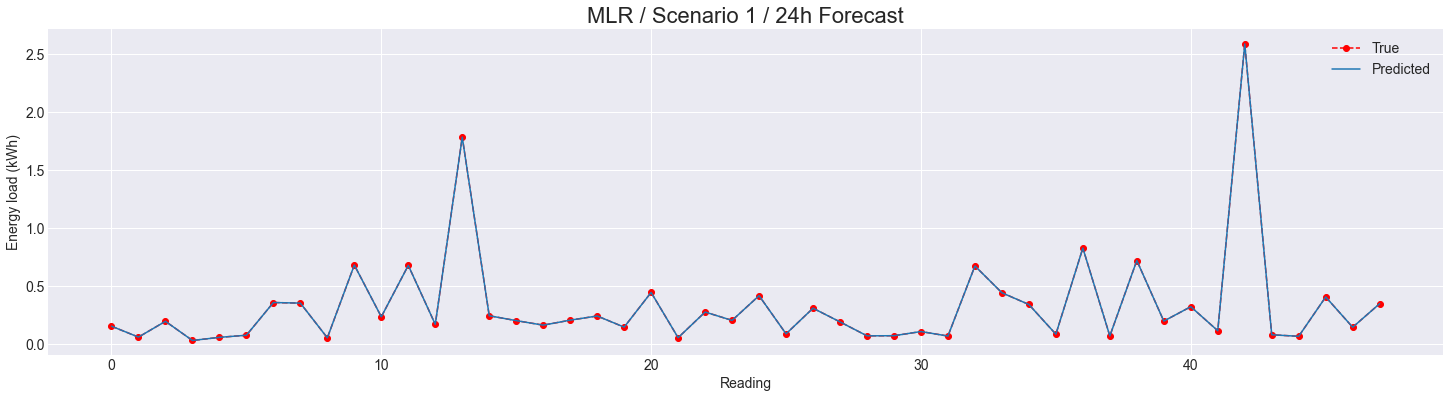

In [50]:
matplotlib.rcParams.update({'font.size': 14})
predicted_mreg = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_mreg['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_mreg['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('MLR / Scenario 1 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario1/S1_24h_MLR.jpeg', dpi = 500)
plt.show()


The model is predicting almost perfectly.

In [51]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario1.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/MLR_Scenario1.joblib']

### support vector regressor (SVR)

In [52]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR

In [53]:
model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 0.124 s


**Prediction**

In [54]:
# make a prediction
yhat = model.predict(test_X)

In [55]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999991149774451
Mse:  0.000001717879794
Rmse: 0.001310679134723
Mae:  0.000936275655141
Mape:  0.547690908284855
Training time: 0.124 s


In [56]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

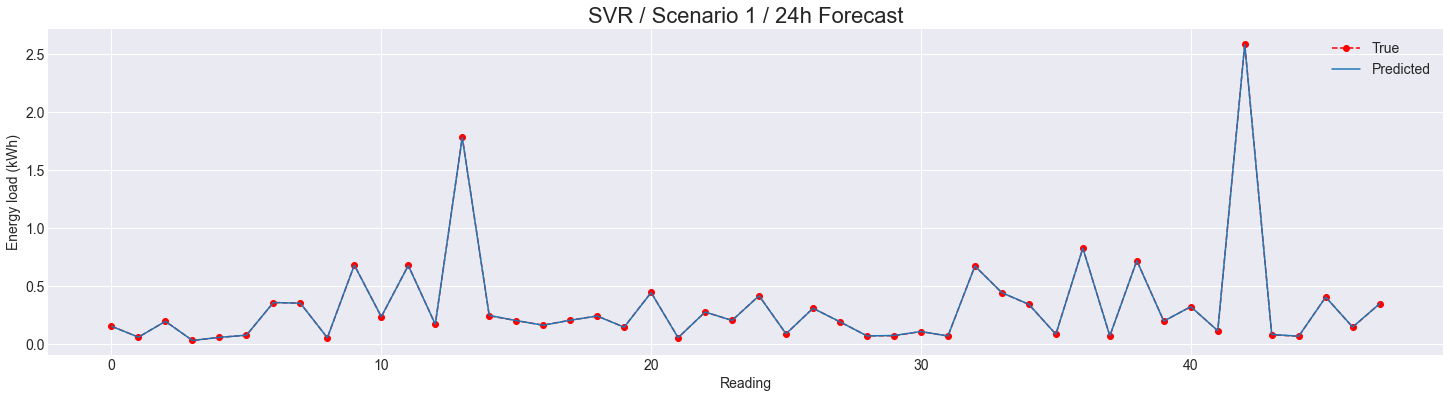

In [57]:
matplotlib.rcParams.update({'font.size': 14})
predicted_svm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_svm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_svm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('SVR / Scenario 1 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario1/S1_24h_SVR.jpeg', dpi = 500)
plt.show()

Although the model picked up on the general trend, it clearly lacks the performance of the MLR.

In [58]:
from joblib import dump, load
dump(model, 'C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario1.joblib')

['C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/SVR_Scenario1.joblib']

### random forest (RF)

In [59]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [60]:
model = RandomForestRegressor(bootstrap= True,
                              max_depth= 110,
                              max_features= 0.33,
                              min_samples_leaf= 3,
                              min_samples_split= 10,
                              n_estimators= 100, 
                              criterion='mse')
start_time = time.time()
model.fit(train_X, train_y)
end_time = time.time()
train_time = end_time - start_time
train_times.append(train_time)
print(f'Training time: {train_time:.3f} s') 

Training time: 22.727 s


**Prediction**

In [61]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],1)

**Prediction**

In [62]:
# make a prediction
yhat = model.predict(test_X)

In [63]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.950684187356632
Mse:  0.006933245710483
Rmse: 0.083266113818786
Mae:  0.023674372223413
Mape:  7.423282312873815
Training time: 22.727 s


In [64]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

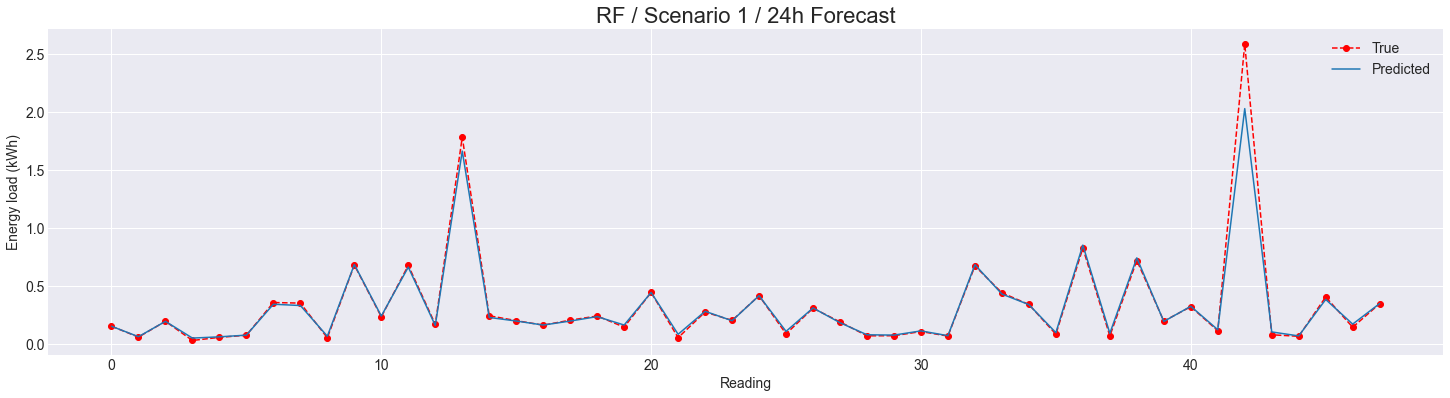

In [65]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rf = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rf['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rf['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RF / Scenario 1 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario1/S1_24h_RF.jpeg', dpi = 500)
plt.show()

### feedforward neural networks (FFNNs)

In [66]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(39480, 1, 33) (39480,) (48, 1, 33) (48,)


In [67]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers import GRU
from keras.layers.convolutional import MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.layers import TimeDistributed
import keras
from keras import layers

In [68]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [69]:
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [70]:
from keras.optimizers import RMSprop

Epoch 1/10
7896/7896 - 5s - loss: 0.0054
Epoch 2/10
7896/7896 - 4s - loss: 6.2956e-04
Epoch 3/10
7896/7896 - 4s - loss: 3.2619e-04
Epoch 4/10
7896/7896 - 5s - loss: 2.2562e-04
Epoch 5/10
7896/7896 - 4s - loss: 1.7873e-04
Epoch 6/10
7896/7896 - 4s - loss: 1.4485e-04
Epoch 7/10
7896/7896 - 5s - loss: 1.2158e-04
Epoch 8/10
7896/7896 - 4s - loss: 1.0172e-04
Epoch 9/10
7896/7896 - 4s - loss: 9.2850e-05
Epoch 10/10
7896/7896 - 4s - loss: 8.2742e-05


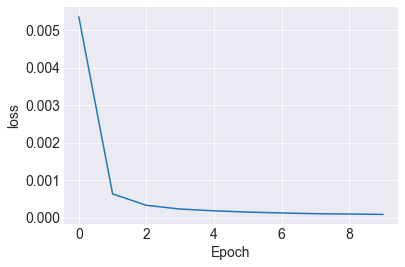

Training time: 44.444 s


In [71]:
model = Sequential()

# Add fully connected layer with a ReLU activation function
model.add(Dense(units=64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units=64, activation='relu'))

# Add fully connected layer with no activation function
model.add(Dense(units=1))

optimizer = keras.optimizers.RMSprop(lr=0.001, momentum= 0.9)

model.compile(loss='mean_squared_error', # Mean squared error
            optimizer ='RMSprop' # Optimization algorithm
            )

start_time = time.time()
history = model.fit(train_X, train_y, epochs=10, batch_size=5, verbose=2, shuffle=False) 
end_time = time.time()
train_time = end_time - start_time
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [72]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [73]:
yhat

array([0.14790338, 0.05496802, 0.1902882 , 0.02748274, 0.05231484,
       0.06901104, 0.35529098, 0.34561795, 0.05046391, 0.6734478 ,
       0.22996558, 0.6753401 , 0.16479367, 1.768701  , 0.24013346,
       0.19449528, 0.15714377, 0.1971501 , 0.23618962, 0.13829271,
       0.43932688, 0.05026745, 0.26792493, 0.19294372, 0.40362164,
       0.07840514, 0.30033287, 0.17912975, 0.06438317, 0.06346114,
       0.09913379, 0.06308969, 0.6697534 , 0.43875778, 0.3321551 ,
       0.07901052, 0.8256466 , 0.06447603, 0.71582437, 0.19188794,
       0.31610325, 0.10637508, 2.5645716 , 0.07396896, 0.06196069,
       0.40513116, 0.13799167, 0.3377961 ], dtype=float32)

In [74]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999695213932558
Mse:  0.000058891321862
Rmse: 0.007674068142900
Mae:  0.006824486500894
Mape:  4.902121665658483
Training time: 44.444 s


In [75]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

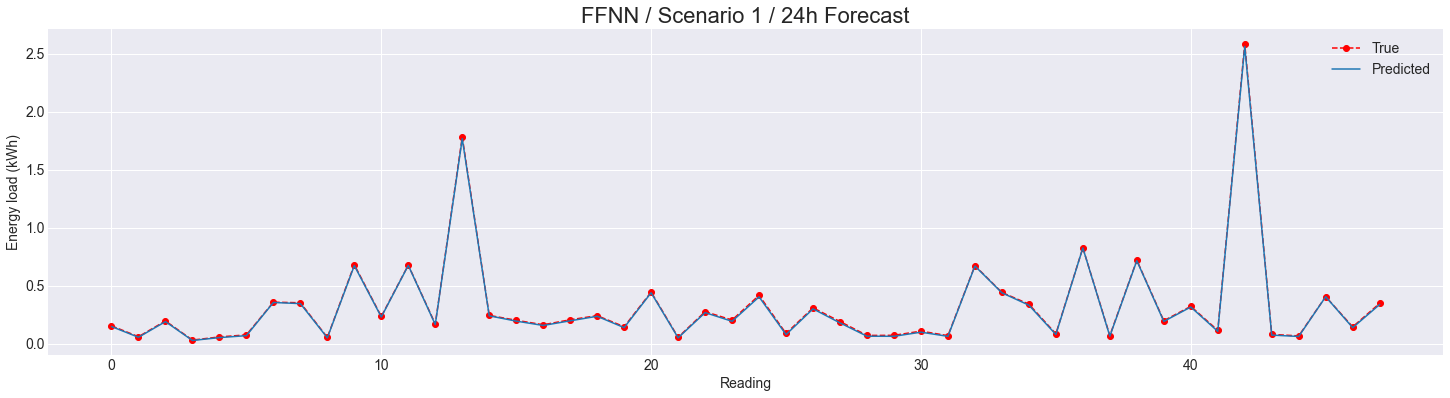

In [76]:
matplotlib.rcParams.update({'font.size': 14})
predicted_fnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_fnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_fnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('FFNN / Scenario 1 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario1/S1_24h_FFNN.jpeg', dpi = 500)
plt.show()

Good predictions, although a bit worse compared to the RF.

### LSTM

In [77]:
from keras.wrappers.scikit_learn import KerasRegressor
# Load libraries
import numpy as np
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

# Set random seed

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

import time

In [78]:
from keras.optimizers import Adam

Epoch 1/30
1645/1645 - 2s - loss: 0.0360
Epoch 2/30
1645/1645 - 2s - loss: 8.9829e-04
Epoch 3/30
1645/1645 - 2s - loss: 4.0752e-04
Epoch 4/30
1645/1645 - 2s - loss: 3.7659e-04
Epoch 5/30
1645/1645 - 2s - loss: 8.7370e-05
Epoch 6/30
1645/1645 - 2s - loss: 1.3413e-04
Epoch 7/30
1645/1645 - 2s - loss: 3.4318e-04
Epoch 8/30
1645/1645 - 2s - loss: 5.6775e-05
Epoch 9/30
1645/1645 - 2s - loss: 8.6904e-05
Epoch 10/30
1645/1645 - 2s - loss: 4.3953e-05
Epoch 11/30
1645/1645 - 2s - loss: 7.5845e-05
Epoch 12/30
1645/1645 - 2s - loss: 1.2136e-04
Epoch 13/30
1645/1645 - 2s - loss: 8.5070e-04
Epoch 14/30
1645/1645 - 2s - loss: 2.9062e-05
Epoch 15/30
1645/1645 - 2s - loss: 8.8106e-05
Epoch 16/30
1645/1645 - 2s - loss: 1.5551e-04
Epoch 17/30
1645/1645 - 2s - loss: 7.4155e-05
Epoch 18/30
1645/1645 - 2s - loss: 5.7115e-05
Epoch 19/30
1645/1645 - 2s - loss: 4.9643e-05
Epoch 20/30
1645/1645 - 2s - loss: 6.7569e-05
Epoch 21/30
1645/1645 - 2s - loss: 1.2102e-04
Epoch 22/30
1645/1645 - 2s - loss: 1.7782e-05
E

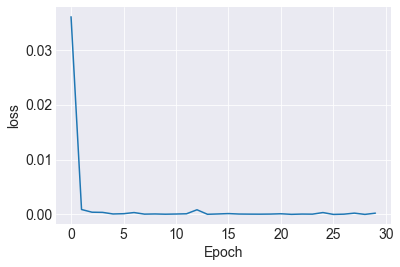

Training time: 52.966 s


In [79]:
# design network
model = Sequential()
model.add(LSTM(128,  activation='softplus', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )

start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

**Prediction**

In [80]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [81]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999926243121638
Mse:  0.000014448879932
Rmse: 0.003801168232505
Mae:  0.003362059826031
Mape:  2.053833700793827
Training time: 52.966 s


In [82]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

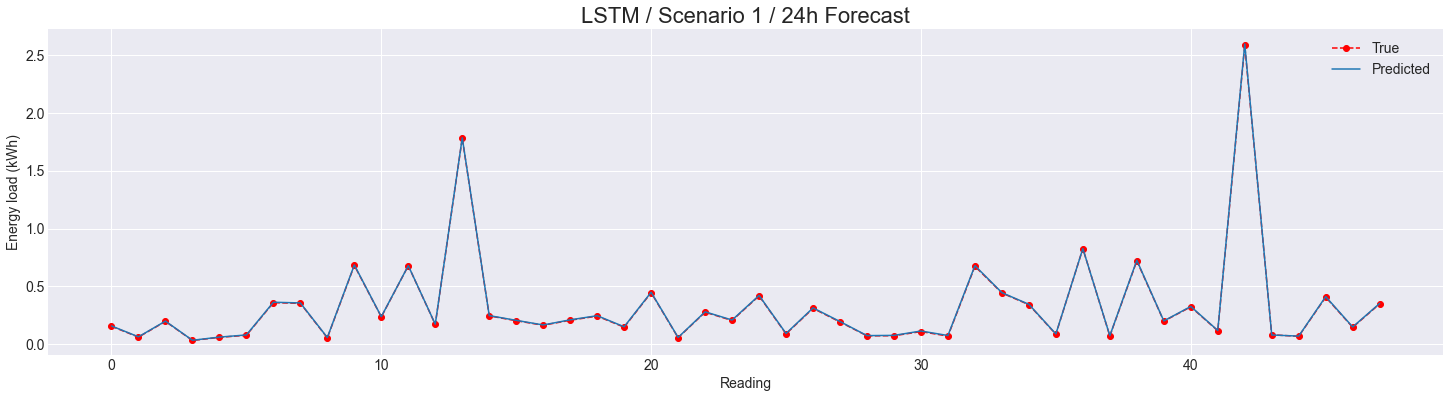

In [83]:
matplotlib.rcParams.update({'font.size': 14})
predicted_lstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_lstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_lstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('LSTM / Scenario 1 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario1/S1_24h_LSTM.jpeg', dpi = 500)
plt.show()

The model is doing well, better than the previous NN, however not as good as MLR and RF.

### RNN

In [84]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.datasets import mnist
from keras.models import Sequential
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Epoch 1/30
1645/1645 - 1s - loss: 0.0130
Epoch 2/30
1645/1645 - 1s - loss: 4.3702e-04
Epoch 3/30
1645/1645 - 1s - loss: 1.2144e-04
Epoch 4/30
1645/1645 - 1s - loss: 3.5472e-04
Epoch 5/30
1645/1645 - 1s - loss: 3.1971e-04
Epoch 6/30
1645/1645 - 1s - loss: 1.5605e-04
Epoch 7/30
1645/1645 - 1s - loss: 1.0517e-04
Epoch 8/30
1645/1645 - 1s - loss: 2.0382e-04
Epoch 9/30
1645/1645 - 1s - loss: 1.1662e-04
Epoch 10/30
1645/1645 - 1s - loss: 1.3646e-04
Epoch 11/30
1645/1645 - 1s - loss: 2.6460e-04
Epoch 12/30
1645/1645 - 1s - loss: 1.3076e-04
Epoch 13/30
1645/1645 - 1s - loss: 8.4573e-05
Epoch 14/30
1645/1645 - 1s - loss: 1.8278e-04
Epoch 15/30
1645/1645 - 1s - loss: 1.0568e-05
Epoch 16/30
1645/1645 - 1s - loss: 2.3913e-04
Epoch 17/30
1645/1645 - 1s - loss: 2.9093e-05
Epoch 18/30
1645/1645 - 1s - loss: 3.8103e-04
Epoch 19/30
1645/1645 - 1s - loss: 7.9107e-05
Epoch 20/30
1645/1645 - 1s - loss: 1.6009e-04
Epoch 21/30
1645/1645 - 1s - loss: 3.1466e-05
Epoch 22/30
1645/1645 - 1s - loss: 4.4032e-05
E

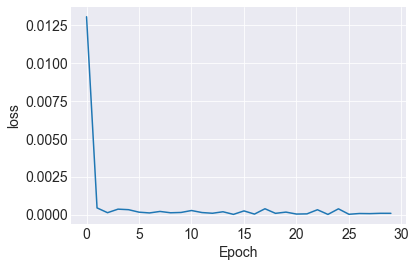

Training time: 35.667 s


In [85]:
# design network
model = Sequential()
model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

optimizer = Adam(lr=0.001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )


start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=24, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [86]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario1.h5')

In [87]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario1.h5")
print("Saved model to disk")
 

Saved model to disk


In [88]:
from keras.models import model_from_json


In [89]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/RNN_Scenario1.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data


Loaded model from disk


**Prediction**

In [90]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [91]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999042229037109
Mse:  0.000179925507245
Rmse: 0.013413631396643
Mae:  0.008303372926700
Mape:  4.919931913845362
Training time: 35.667 s


In [92]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

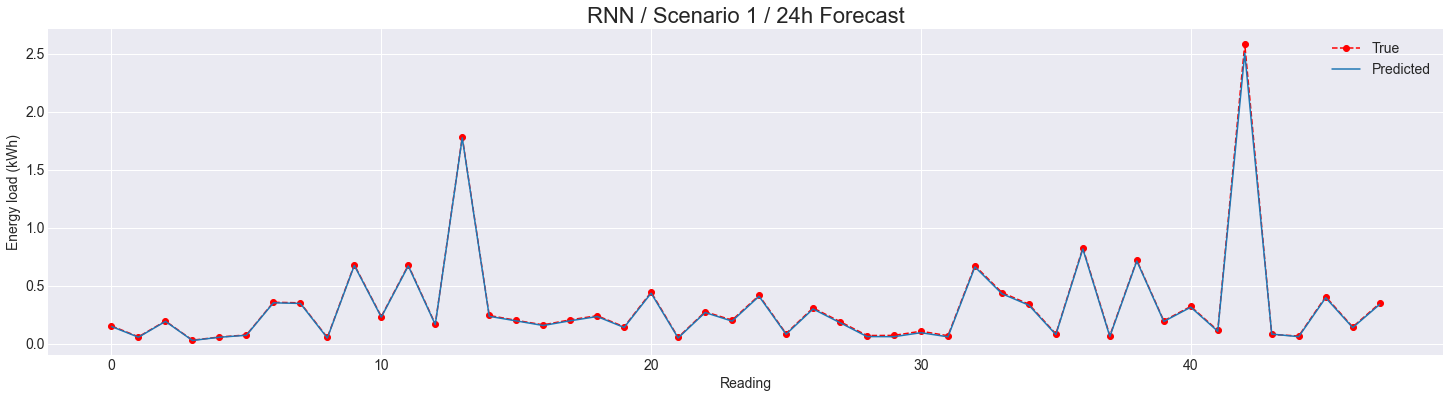

In [93]:
matplotlib.rcParams.update({'font.size': 14})
predicted_rnn = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_rnn['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_rnn['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN / Scenario 1 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario1/S1_24h_RNN.jpeg', dpi = 500)
plt.show()

### Dense + LSTM

Epoch 1/30
617/617 - 1s - loss: 0.0769
Epoch 2/30
617/617 - 1s - loss: 0.0149
Epoch 3/30
617/617 - 2s - loss: 7.3366e-04
Epoch 4/30
617/617 - 1s - loss: 5.3771e-04
Epoch 5/30
617/617 - 2s - loss: 4.1760e-04
Epoch 6/30
617/617 - 1s - loss: 3.4470e-04
Epoch 7/30
617/617 - 1s - loss: 2.9874e-04
Epoch 8/30
617/617 - 1s - loss: 2.5758e-04
Epoch 9/30
617/617 - 2s - loss: 2.2133e-04
Epoch 10/30
617/617 - 2s - loss: 1.8296e-04
Epoch 11/30
617/617 - 1s - loss: 1.6237e-04
Epoch 12/30
617/617 - 1s - loss: 1.3440e-04
Epoch 13/30
617/617 - 1s - loss: 1.1227e-04
Epoch 14/30
617/617 - 1s - loss: 9.4694e-05
Epoch 15/30
617/617 - 2s - loss: 8.9287e-05
Epoch 16/30
617/617 - 2s - loss: 8.7514e-05
Epoch 17/30
617/617 - 2s - loss: 7.7245e-05
Epoch 18/30
617/617 - 1s - loss: 7.1586e-05
Epoch 19/30
617/617 - 1s - loss: 6.4798e-05
Epoch 20/30
617/617 - 1s - loss: 6.1245e-05
Epoch 21/30
617/617 - 2s - loss: 5.3994e-05
Epoch 22/30
617/617 - 1s - loss: 6.6699e-05
Epoch 23/30
617/617 - 1s - loss: 4.8711e-05
Epoch

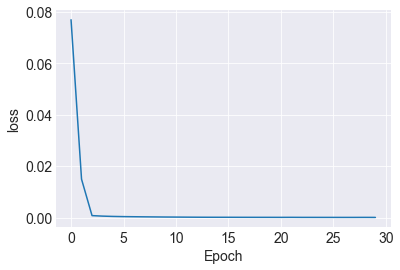

Training time: 42.547 s


In [94]:
# design network
model = Sequential()
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(LSTM(128))
model.add(Dense(1))
optimizer = Adam(lr=0.0001)

model.compile(loss='mean_squared_error', # Mean squared error
             optimizer = optimizer # Optimization algorithm
            )

#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc']) #mae

start_time = time.time()
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=64, verbose=2, shuffle=False)
end_time = time.time()
# plot history
plt.plot(history.history['loss'], label='train')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()
train_time = end_time - start_time
print(f'Training time: {train_time:.3f} s') 
train_times.append(train_time)

In [95]:
model.save('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/models_saved/dense_LSTM_Scenario1_24h.h5')

**Prediction**

In [96]:
# make a prediction
yhat = model.predict(test_X)
yhat = yhat.ravel()

In [97]:
r2 = r2_score(yhat,test_y.ravel())
mse = mean_squared_error(yhat, test_y.ravel())
rmse = mean_squared_error(yhat, test_y.ravel(), squared=False)
mae = mean_absolute_error(yhat, test_y.ravel())
mape = mean_absolute_percentage_error(yhat, test_y.ravel())

print(f'R2:   {r2:.15f}')
print(f'Mse:  {mse:.15f}')
print(f'Rmse: {rmse:.15f}')
print(f'Mae:  {mae:.15f}')
print(f'Mape:  {mape:.15f}')
print(f'Training time: {train_time:.3f} s') 

R2:   0.999769553773251
Mse:  0.000045594307578
Rmse: 0.006752355705790
Mae:  0.003664533646467
Mape:  2.290113792082024
Training time: 42.547 s


In [98]:
R2_scores.append(r2)
MSE_scores.append(mse)
RMSE_scores.append(rmse)
MAE_scores.append(mae)
MAPE_scores.append(mape)

**Comparing Actual and Predictions**

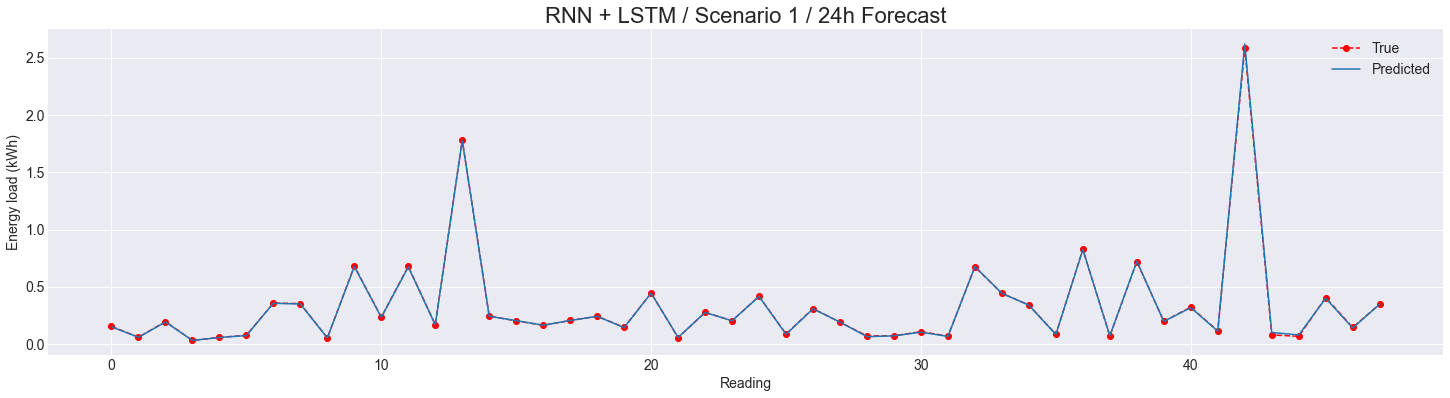

In [99]:
matplotlib.rcParams.update({'font.size': 14})
predicted_denselstm = pd.DataFrame({'predicted':yhat,'energy(kWh/hh)':test_y.ravel()})
predicted_denselstm['energy(kWh/hh)'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
predicted_denselstm['predicted'].plot()
  # style

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

plt.title('RNN + LSTM / Scenario 1 / 24h Forecast', fontdict={'size':22})
plt.xlabel('Reading')
plt.ylabel('Energy load (kWh)')
plt.grid(b=True, which='major', color='w', linewidth=1.0)
plt.legend(['True','Predicted'])
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario1/S1_24h_RNN_LSTM.jpeg', dpi = 500)
plt.show()

This is the best model, the predictions accurately follow the observed energy consumption.


## Best model

In [ ]:
# models_performances = pd.DataFrame([R2_scores,MSE_scores,RMSE_scores,MAE_scores,MAPE_scores,train_times],
#                                    columns=models_predictions, 
#                                    index=['R2_scores', 'MSE_scores', 'RMSE_scores',
#                                           'MAE_scores', 'MAPE_scores', 'Train_Time'])
# models_performances

MLR       SVM         RF      FFNNs       LSTM  \
R2_scores    1.000000e+00  0.999991   0.950139   0.999730   0.999794   
MSE_scores   1.027389e-16  0.000002   0.006998   0.000051   0.000040   
RMSE_scores  1.013602e-08  0.001311   0.083656   0.007155   0.006364   
MAE_scores   6.200420e-09  0.000936   0.023866   0.005284   0.005936   
MAPE_scores  1.973531e-06  0.547691   7.475945   3.481337   5.819654   
Train_Time   2.892160e-02  0.112731  24.982208  53.121985  59.873935   

                   RNN  Dense+LSTM  
R2_scores     0.999909    0.998999  
MSE_scores    0.000017    0.000195  
RMSE_scores   0.004183    0.013962  
MAE_scores    0.002117    0.012815  
MAPE_scores   1.077050    7.555819  
Train_Time   40.200561   40.713158

In [ ]:
# models_performances.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/BestModel_Scenario1.csv', index=False)

Most models are returning similar scores, except for the SVM, which is significantly under-performing. 

The best performance, in terms of all the metrics measured except for training time, is the neural network with dense layers combined with LSTM.

**Plotting all models together.**

In [118]:
prev_day = train_y[-48:] #energy readings from previous day
y_plotting = np.concatenate([prev_day, test_y], axis=0)

In [119]:

# Get all predictions from the models
predicted_energy=[predicted_mreg['predicted'],
                  predicted_svm['predicted'],
                  predicted_rf['predicted'],
                  predicted_fnn['predicted'],
                  predicted_lstm['predicted'],
                  predicted_rnn['predicted'],
                  predicted_denselstm['predicted']]

In [120]:
prev_2days = sorted(pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario1.csv').time)[-96:]

In [121]:
df_for_plotting = pd.DataFrame(y_plotting, index=prev_2days, columns=['Original'])

In [122]:
# Initialize all columns with null values
df_for_plotting["Train"] = np.nan
# Add a column for each model's predictions
col_names=['MLR', 'SVR', 'RF', 'FFNN', 'LSTM', 'RNN', 'Dense-LSTM']
for col_name in col_names:
  df_for_plotting[col_name+' forecast'] = np.nan

In [123]:
# Fill in with corresponding values
df_for_plotting["Train"][:-48] = prev_day

for i, model_pred in enumerate(predicted_energy):
  df_for_plotting[col_names[i]+' forecast'][-48:] = model_pred

In [124]:
# Turn index to datetime
df_for_plotting.index = pd.to_datetime(df_for_plotting.index)

In [125]:
df_for_plotting.columns

Index(['Original', 'Train', 'MLR forecast', 'SVR forecast', 'RF forecast',
       'FFNN forecast', 'LSTM forecast', 'RNN forecast',
       'Dense-LSTM forecast'],
      dtype='object')

In [126]:
import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

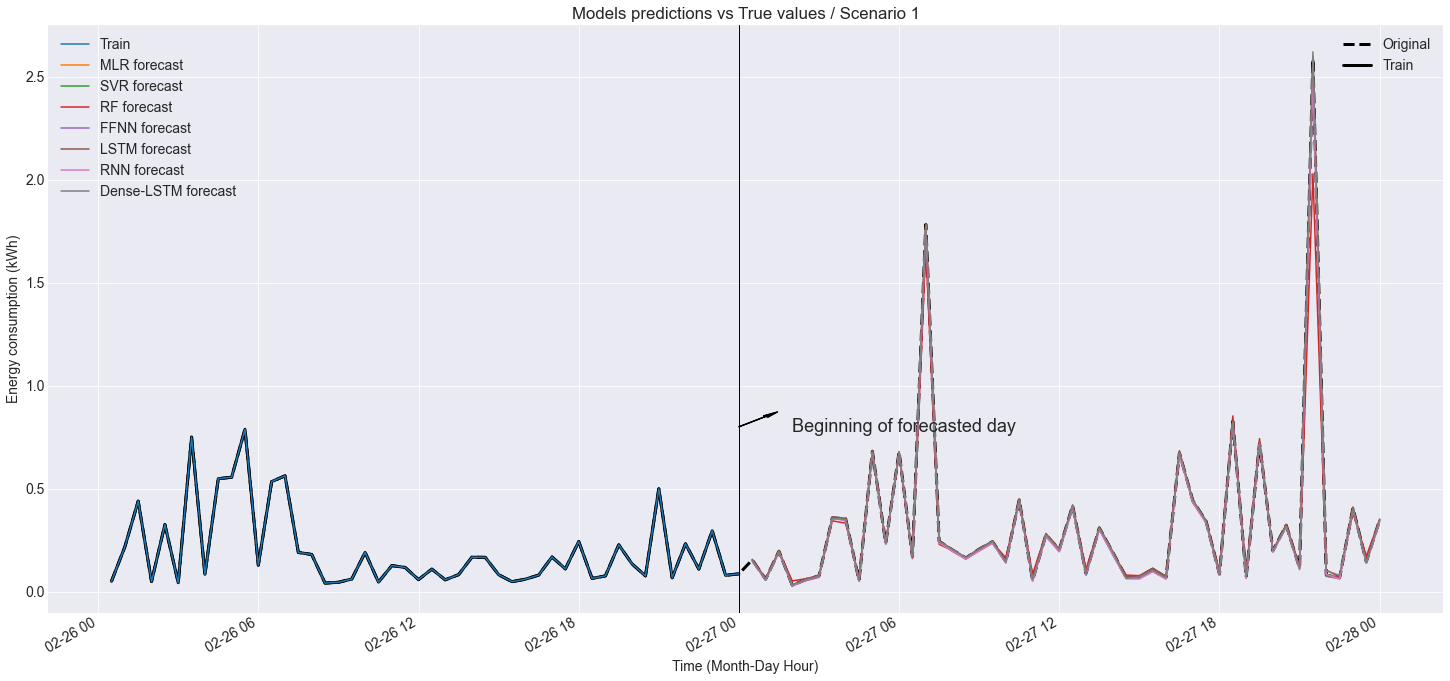

In [127]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)


# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='K', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[1:]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)


# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.8, dx, 0.05, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)


plt.title('Models predictions vs True values / Scenario 1')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario1/S1_24h_OriginalPredicted_All.jpeg', dpi = 500)
plt.show()

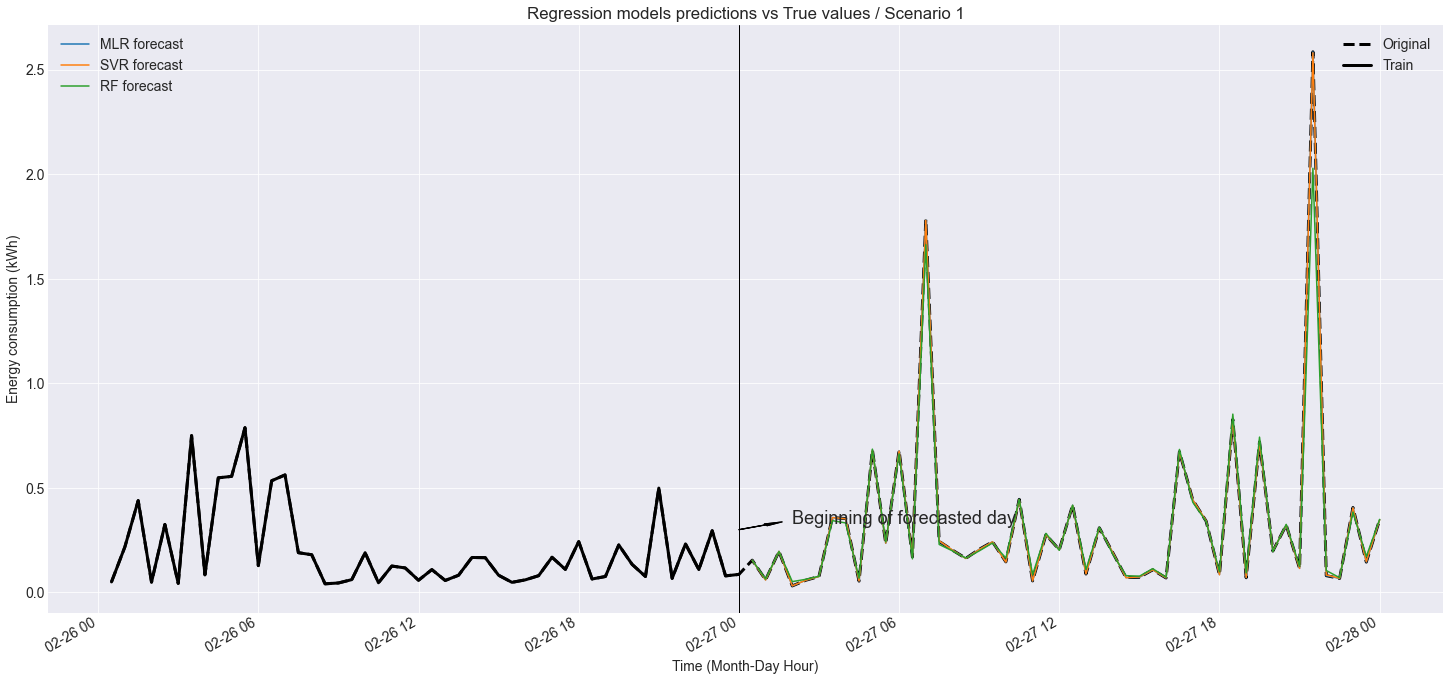

In [128]:
import matplotlib.dates as md

fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[2:5]:
  df_for_plotting[forecast].plot(label=forecast)

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.35, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.3, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Regression models predictions vs True values / Scenario 1')

plt.legend()
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario1/S1_24h_RegressionModelsPredicted_All.jpeg', dpi = 500)
plt.show()

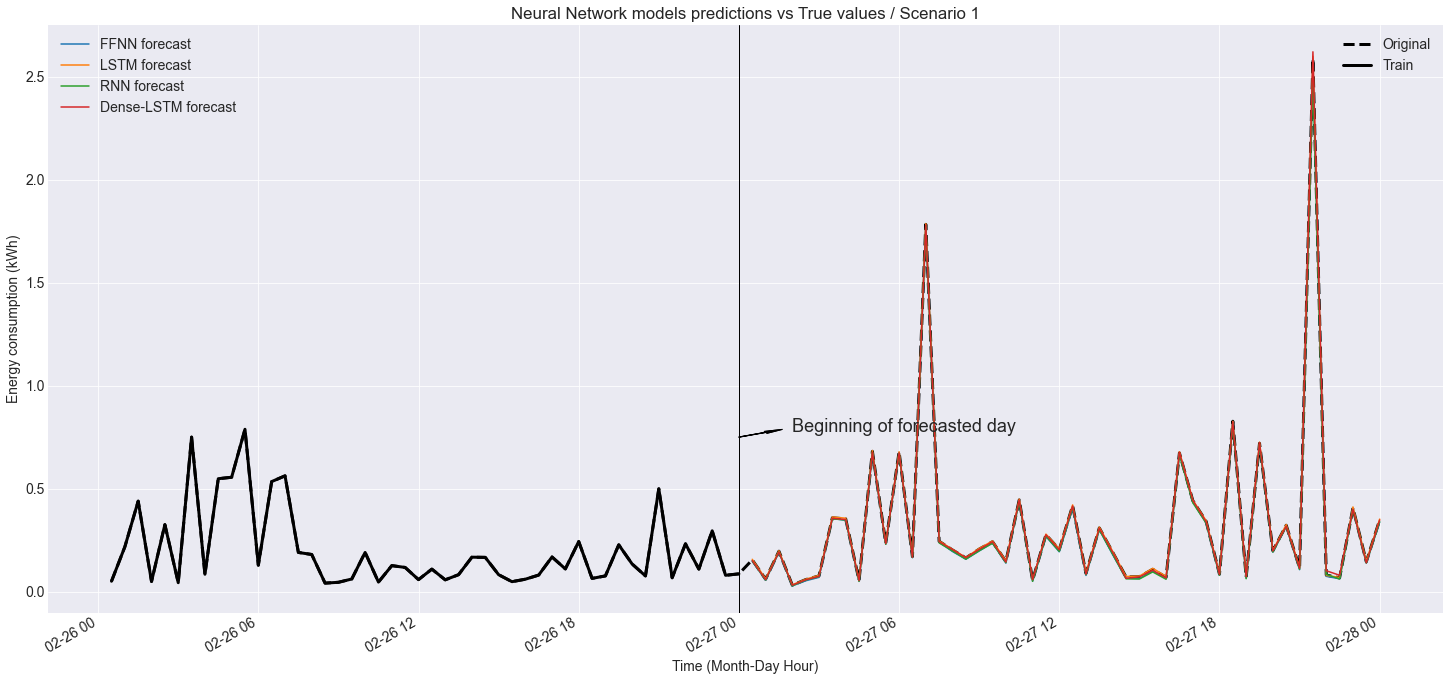

In [129]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(111)

# Plot the original and train data, and create a separate legend for them
l1, = plt.plot(df_for_plotting['Original'], linestyle='dashed', color='k', linewidth=3)
l2, = plt.plot(df_for_plotting['Train'], color='k', linewidth=3)
legend1 = plt.legend((l1,l2), ['Original','Train'], loc=1)

for forecast in df_for_plotting.columns[5:]:
  df_for_plotting[forecast].plot()

plt.ylabel('Energy consumption (kWh)')

middle = pd.to_datetime('2014-02-27') #middle of the graph

# Draw vertical line separating train and forecasted data
plt.axvline(middle, color='k', lw=1)
# Label the vertical line
label_x_pos = pd.to_datetime('2014-02-27 02:00')
plt.text(label_x_pos, 0.8, 'Beginning of forecasted day', 
         horizontalalignment='left', verticalalignment='center',
         fontsize=18)

# Arrow to point from the label to the vertical line
x0 = md.date2num(datetime.datetime(2014,2,27))
dx = md.date2num(datetime.datetime(2014,2,27,1)) - x0
arr = plt.arrow(x0, 0.75, dx, 0.023, head_width=0.01, head_length=0.03, fc='k', ec='k')
ax.add_patch(arr)

plt.title('Neural Network models predictions vs True values / Scenario 1')
plt.legend(loc='upper left')
plt.xlabel('Time (Month-Day Hour)')
plt.gca().add_artist(legend1)
plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario1/S1_24h_OriginalPredicted_4_8.jpeg', dpi = 500)
plt.show()

## House level prediction 
-For each half hour, for each of the 33 types.

In [100]:
houses_data = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/all_houses_Scenario4.csv')

In [ ]:
houses_data

LCLid                 tstp  energy(kWh/hh)
0            2  2012-10-12 00:30:00           0.000
1            2  2012-10-12 01:00:00           0.000
2            2  2012-10-12 01:30:00           0.000
3            2  2012-10-12 02:00:00           0.000
4            2  2012-10-12 02:30:00           0.000
...        ...                  ...             ...
8092712   5124  2014-02-27 22:00:00           0.673
8092713   5124  2014-02-27 22:30:00           0.590
8092714   5124  2014-02-27 23:00:00           0.552
8092715   5124  2014-02-27 23:30:00           0.519
8092716   5124  2014-02-28 00:00:00           0.390

[8092717 rows x 3 columns]

In [101]:
houses_data.rename(columns={'tstp':'time'}, inplace=True)

Merging with the weather_energy data

In [102]:
weather_energy = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/weather_energy_Scenario4.csv')

In [103]:
weather_energy.columns[1:]

Index(['year', 'month', 'day', 'hour', 'weekday', 'energy(kWh/hh)',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity', 'holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'weekend'],
      dtype='object')

In [104]:
weather_energy = weather_energy.drop(columns = ['holiday_ind',
       'stdorToU', 'Acorn', 'Acorn_grouped', 'year', 'month', 'day', 'hour', 'weekday', 'weekend'])

In [105]:
updated_houses = houses_data.merge(weather_energy, on='time')

In [106]:
updated_houses

LCLid                 time  energy(kWh/hh)_x  energy(kWh/hh)_y  \
0            2  2012-10-12 00:30:00             0.000             0.135   
1          246  2012-10-12 00:30:00             0.975             0.135   
2         1074  2012-10-12 00:30:00             1.438             0.135   
3         3281  2012-10-12 00:30:00             0.078             0.135   
4         3305  2012-10-12 00:30:00             0.101             0.135   
...        ...                  ...               ...               ...   
8086036    183  2011-12-03 06:30:00             0.109             0.109   
8086037    183  2011-12-03 07:00:00             0.030             0.030   
8086038    183  2011-12-03 07:30:00             0.082             0.082   
8086039    183  2011-12-03 08:00:00             0.030             0.030   
8086040    183  2011-12-03 08:30:00             0.365             0.365   

         visibility  windBearing  temperature  dewPoint  pressure  \
0             11.76          234        13.61     12.21    999.47   
1             11.76          234        13.61     12.21    999.47   
2             11.76          234        13.61     12.21    999.47   
3             11.76          234        13.61     12.21    999.47   
4             11.76          234        13.61     12.21    999.47   
...             ...          ...          ...       ...       ...   
8086036       11.73          244        11.00     10.26   1001.07   
8086037       11.93          253        10.96      9.73   1001.07   
8086038       11.93          253        10.96      9.73   1001.07   
8086039       13.71          253        11.01      9.11   1001.55   
8086040       13.71          253        11.01      9.11   1001.55   

         apparentTemperature  windSpeed  humidity  
0                      13.61       5.40      0.91  
1                      13.61       5.40      0.91  
2                      13.61       5.40      0.91  
3                      13.61       5.40      0.91  
4                      13.61       5.40      0.91  
...                      ...        ...       ...  
8086036                11.00       6.37      0.95  
8086037                10.96       5.48      0.92  
8086038                10.96       5.48      0.92  
8086039                11.01       6.32      0.88  
8086040                11.01       6.32      0.88  

[8086041 rows x 12 columns]

In [107]:
updated_houses.columns

Index(['LCLid', 'time', 'energy(kWh/hh)_x', 'energy(kWh/hh)_y', 'visibility',
       'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'],
      dtype='object')

In [108]:
updated_houses.columns = ['LCLid', 'time', 'energy(kWh/hh)', 'energy(kWh/hh)_y', 'visibility',
       'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity']

In [109]:
updated_houses.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S1.csv')

In [110]:
updated_houses = pd.read_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/data_computed/updated_houses_S1.csv')

In [111]:
updated_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8086041 entries, 0 to 8086040
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   LCLid                int64  
 2   time                 object 
 3   energy(kWh/hh)       float64
 4   energy(kWh/hh)_y     float64
 5   visibility           float64
 6   windBearing          int64  
 7   temperature          float64
 8   dewPoint             float64
 9   pressure             float64
 10  apparentTemperature  float64
 11  windSpeed            float64
 12  humidity             float64
dtypes: float64(9), int64(3), object(1)
memory usage: 802.0+ MB


In [112]:
updated_houses.columns

Index(['Unnamed: 0', 'LCLid', 'time', 'energy(kWh/hh)', 'energy(kWh/hh)_y',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity'],
      dtype='object')

In [113]:
updated_houses.columns = ['Unnamed: 0', 'LCLid', 'time', 'energy(kWh/hh)', 'energy(kWh/hh)_y',
       'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity']

In [114]:
updated_houses


Unnamed: 0  LCLid                 time  energy(kWh/hh)  \
0                 0      2  2012-10-12 00:30:00           0.000   
1                 1    246  2012-10-12 00:30:00           0.975   
2                 2   1074  2012-10-12 00:30:00           1.438   
3                 3   3281  2012-10-12 00:30:00           0.078   
4                 4   3305  2012-10-12 00:30:00           0.101   
...             ...    ...                  ...             ...   
8086036     8086036    183  2011-12-03 06:30:00           0.109   
8086037     8086037    183  2011-12-03 07:00:00           0.030   
8086038     8086038    183  2011-12-03 07:30:00           0.082   
8086039     8086039    183  2011-12-03 08:00:00           0.030   
8086040     8086040    183  2011-12-03 08:30:00           0.365   

         energy(kWh/hh)_y  visibility  windBearing  temperature  dewPoint  \
0                   0.135       11.76          234        13.61     12.21   
1                   0.135       11.76          234        13.61     12.21   
2                   0.135       11.76          234        13.61     12.21   
3                   0.135       11.76          234        13.61     12.21   
4                   0.135       11.76          234        13.61     12.21   
...                   ...         ...          ...          ...       ...   
8086036             0.109       11.73          244        11.00     10.26   
8086037             0.030       11.93          253        10.96      9.73   
8086038             0.082       11.93          253        10.96      9.73   
8086039             0.030       13.71          253        11.01      9.11   
8086040             0.365       13.71          253        11.01      9.11   

         pressure  apparentTemperature  windSpeed  humidity  
0          999.47                13.61       5.40      0.91  
1          999.47                13.61       5.40      0.91  
2          999.47                13.61       5.40      0.91  
3          999.47                13.61       5.40      0.91  
4          999.47                13.61       5.40      0.91  
...           ...                  ...        ...       ...  
8086036   1001.07                11.00       6.37      0.95  
8086037   1001.07                10.96       5.48      0.92  
8086038   1001.07                10.96       5.48      0.92  
8086039   1001.55                11.01       6.32      0.88  
8086040   1001.55                11.01       6.32      0.88  

[8086041 rows x 13 columns]

Function to check another household:

In [115]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [116]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [117]:
from keras.models import Sequential, load_model
from joblib import dump, load


In [ ]:
updated_houses

Unnamed: 0  LCLid                 time  energy(kWh/hh)  \
0                 0      2  2012-10-12 00:30:00           0.000   
1                 1    246  2012-10-12 00:30:00           0.975   
2                 2   1074  2012-10-12 00:30:00           1.438   
3                 3   3281  2012-10-12 00:30:00           0.078   
4                 4   3305  2012-10-12 00:30:00           0.101   
...             ...    ...                  ...             ...   
8086036     8086036    183  2011-12-03 06:30:00           0.109   
8086037     8086037    183  2011-12-03 07:00:00           0.030   
8086038     8086038    183  2011-12-03 07:30:00           0.082   
8086039     8086039    183  2011-12-03 08:00:00           0.030   
8086040     8086040    183  2011-12-03 08:30:00           0.365   

         energy(kWh/hh)_y  visibility  windBearing  temperature  dewPoint  \
0                   0.135       11.76          234        13.61     12.21   
1                   0.135       11.76          234        13.61     12.21   
2                   0.135       11.76          234        13.61     12.21   
3                   0.135       11.76          234        13.61     12.21   
4                   0.135       11.76          234        13.61     12.21   
...                   ...         ...          ...          ...       ...   
8086036             0.109       11.73          244        11.00     10.26   
8086037             0.030       11.93          253        10.96      9.73   
8086038             0.082       11.93          253        10.96      9.73   
8086039             0.030       13.71          253        11.01      9.11   
8086040             0.365       13.71          253        11.01      9.11   

         pressure  apparentTemperature  windSpeed  humidity  
0          999.47                13.61       5.40      0.91  
1          999.47                13.61       5.40      0.91  
2          999.47                13.61       5.40      0.91  
3          999.47                13.61       5.40      0.91  
4          999.47                13.61       5.40      0.91  
...           ...                  ...        ...       ...  
8086036   1001.07                11.00       6.37      0.95  
8086037   1001.07                10.96       5.48      0.92  
8086038   1001.07                10.96       5.48      0.92  
8086039   1001.55                11.01       6.32      0.88  
8086040   1001.55                11.01       6.32      0.88  

[8086041 rows x 13 columns]

In [ ]:
updated_houses[updated_houses.LCLid==2]

Unnamed: 0  LCLid                 time  energy(kWh/hh)  \
0                 0      2  2012-10-12 00:30:00           0.000   
258             258      2  2012-10-12 01:00:00           0.000   
516             516      2  2012-10-12 01:30:00           0.000   
774             774      2  2012-10-12 02:00:00           0.000   
1032           1032      2  2012-10-12 02:30:00           0.000   
...             ...    ...                  ...             ...   
6499697     6499697      2  2014-02-27 22:00:00           0.416   
6499954     6499954      2  2014-02-27 22:30:00           1.350   
6500211     6500211      2  2014-02-27 23:00:00           1.247   
6500468     6500468      2  2014-02-27 23:30:00           1.218   
6500725     6500725      2  2014-02-28 00:00:00           1.387   

         energy(kWh/hh)_y  visibility  windBearing  temperature  dewPoint  \
0                   0.135       11.76          234        13.61     12.21   
258                 0.094       13.50          250        13.09     11.37   
516                 0.125       13.50          250        13.09     11.37   
774                 0.081       13.50          252        12.54     10.27   
1032                0.132       13.50          252        12.54     10.27   
...                   ...         ...          ...          ...       ...   
6499697             0.171       14.00          216         4.10      1.64   
6499954             0.504       14.00          216         4.10      1.64   
6500211             0.176       14.03          200         3.93      1.61   
6500468             0.136       14.03          200         3.93      1.61   
6500725             0.055       12.63          190         3.81      1.53   

         pressure  apparentTemperature  windSpeed  humidity  
0          999.47                13.61       5.40      0.91  
258       1000.10                13.09       6.77      0.89  
516       1000.10                13.09       6.77      0.89  
774       1000.51                12.54       6.46      0.86  
1032      1000.51                12.54       6.46      0.86  
...           ...                  ...        ...       ...  
6499697   1005.67                 1.41       3.02      0.84  
6499954   1005.67                 1.41       3.02      0.84  
6500211   1004.62                 1.42       2.75      0.85  
6500468   1004.62                 1.42       2.75      0.85  
6500725   1003.57                 1.47       2.53      0.85  

[24116 rows x 13 columns]

In [ ]:
weather_energy

time  energy(kWh/hh)  visibility  windBearing  \
0      2011-11-26 11:30:00           0.127       13.07          238   
1      2011-11-26 12:00:00           0.178       12.83          239   
2      2011-11-26 12:30:00           0.352       12.83          239   
3      2011-11-26 13:00:00           0.215       13.07          243   
4      2011-11-26 13:30:00           0.135       13.07          243   
...                    ...             ...         ...          ...   
39547  2014-01-30 02:00:00           0.080        4.78           40   
39548  2014-02-04 05:30:00           0.067       13.81          225   
39549  2014-02-09 17:30:00           0.406       12.15          231   
39550  2014-02-15 07:30:00           0.145       12.39          228   
39551  2014-02-15 19:30:00           0.348       12.68          247   

       temperature  dewPoint  pressure  apparentTemperature  windSpeed  \
0            11.92      7.58   1026.96                11.92       7.21   
1            12.48      7.31   1026.25                12.48       7.48   
2            12.48      7.31   1026.25                12.48       7.48   
3            12.61      7.57   1025.28                12.61       8.15   
4            12.61      7.57   1025.28                12.61       8.15   
...            ...       ...       ...                  ...        ...   
39547         4.18      2.69   1000.13                 1.26       3.37   
39548         5.63      2.26    998.42                 2.71       3.85   
39549         6.72     -1.73    988.90                 2.94       6.33   
39550         8.59      2.30    983.69                 3.92      12.02   
39551         7.39      3.06    997.07                 3.91       6.08   

       humidity  
0          0.75  
1          0.71  
2          0.71  
3          0.71  
4          0.71  
...         ...  
39547      0.90  
39548      0.79  
39549      0.55  
39550      0.65  
39551      0.74  

[39552 rows x 10 columns]

In [130]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

In [133]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-48), :]
  test = reframed[(len(reframed)-48):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  
  # Tranform the test set
  #train_X = scaler.fit_transform(train_X)
  #test_X = scaler.transform(test_X)

  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))




  model = Sequential()
  model.add(SimpleRNN(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))

  optimizer = Adam(lr=0.001)

  model.compile(loss='mean_squared_error', # Mean squared error
              optimizer = optimizer # Optimization algorithm
              )

  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /RNN (Scenario 1)')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario1/2_singleHouseholdLevel/best_NN_model/S1_24h_RNN_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


Mse:  17591.227374668353150
Rmse: 132.631924417420521
Mae:  132.545055609351635
Mape:  99.871070369232967


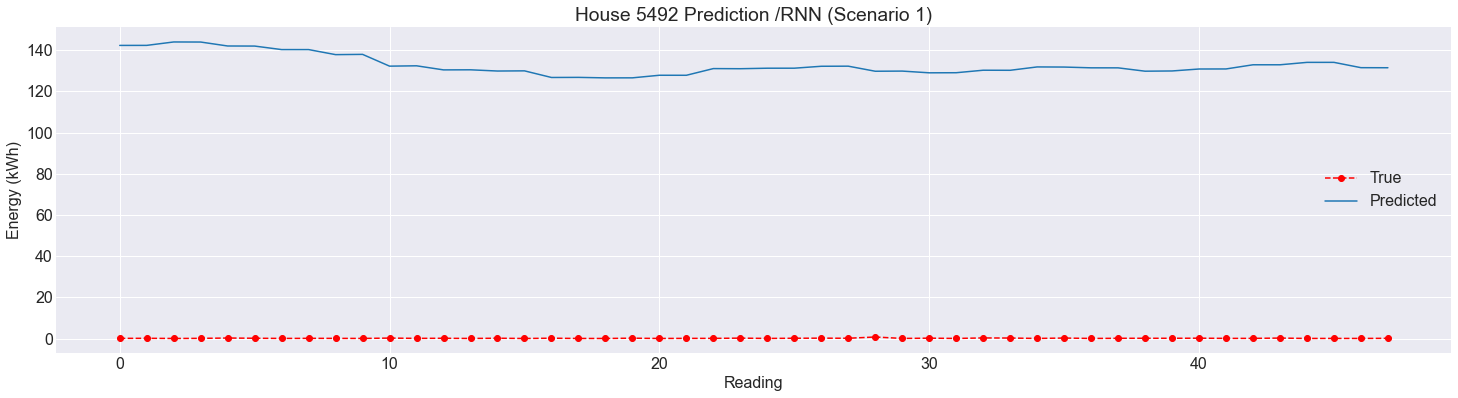

Mse:  10199.323229534471466
Rmse: 100.991698814974256
Mae:  100.977681948182479
Mape:  99.758649568408458


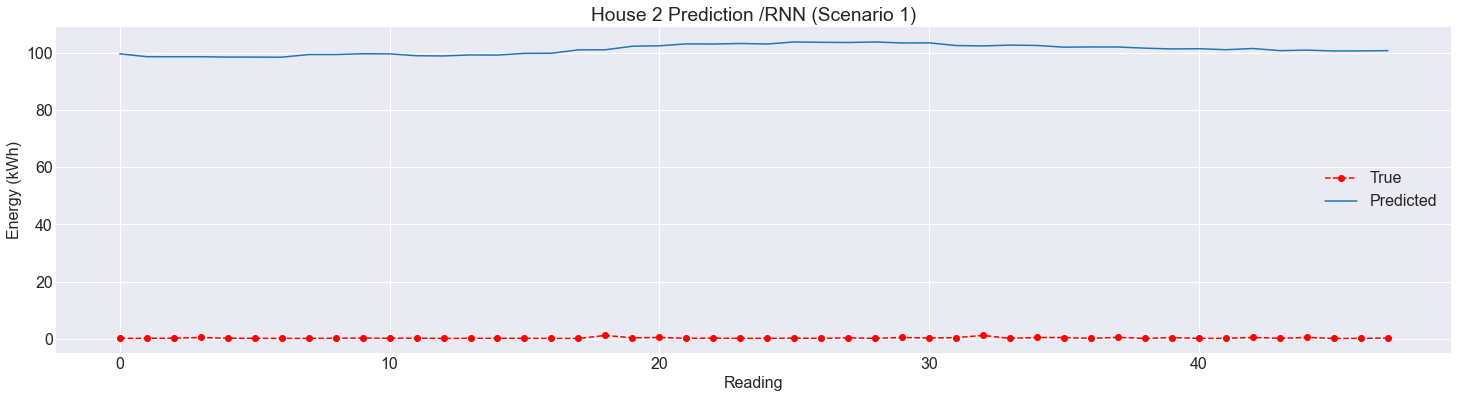

Mse:  16057.593339421486235
Rmse: 126.718559569707409
Mae:  126.715895091804370
Mape:  100.559948625102422


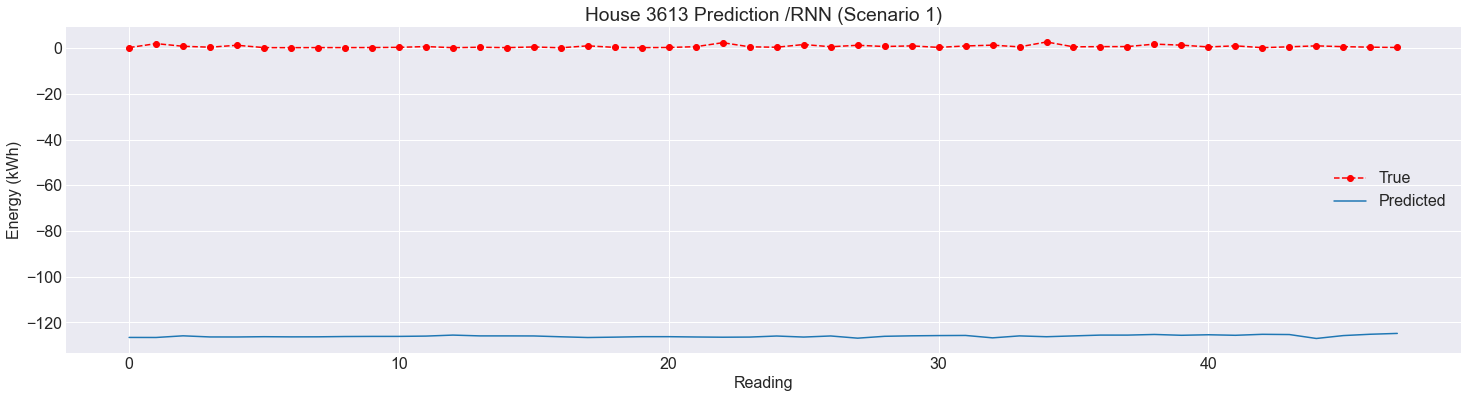

Mse:  81.078543046773419
Rmse: 9.004362445324679
Mae:  8.677510017373910
Mape:  101.871530856485435


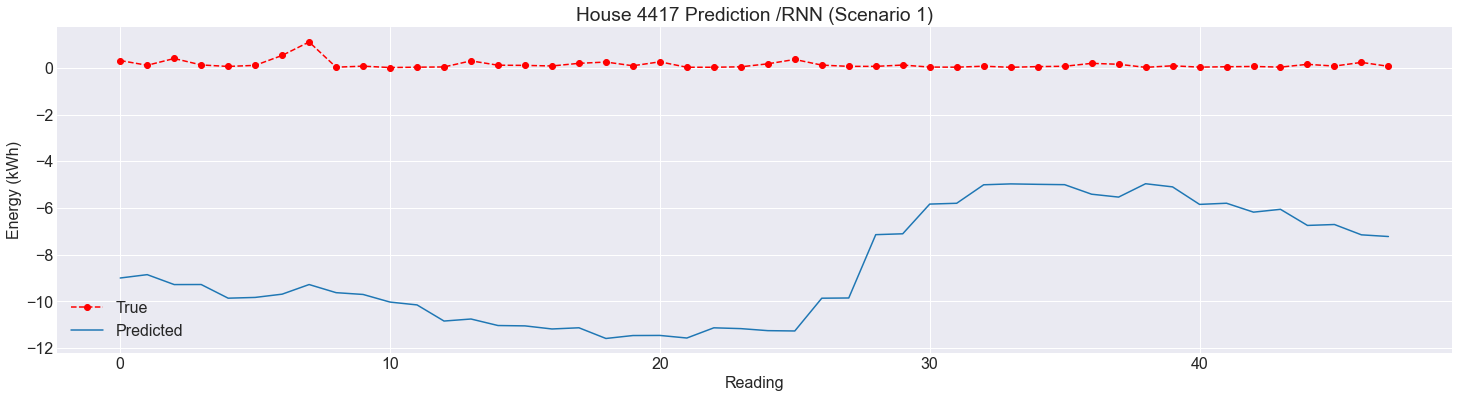

Mse:  2978.675510266137735
Rmse: 54.577243520226794
Mae:  54.401938883493131
Mape:  99.880926154585183


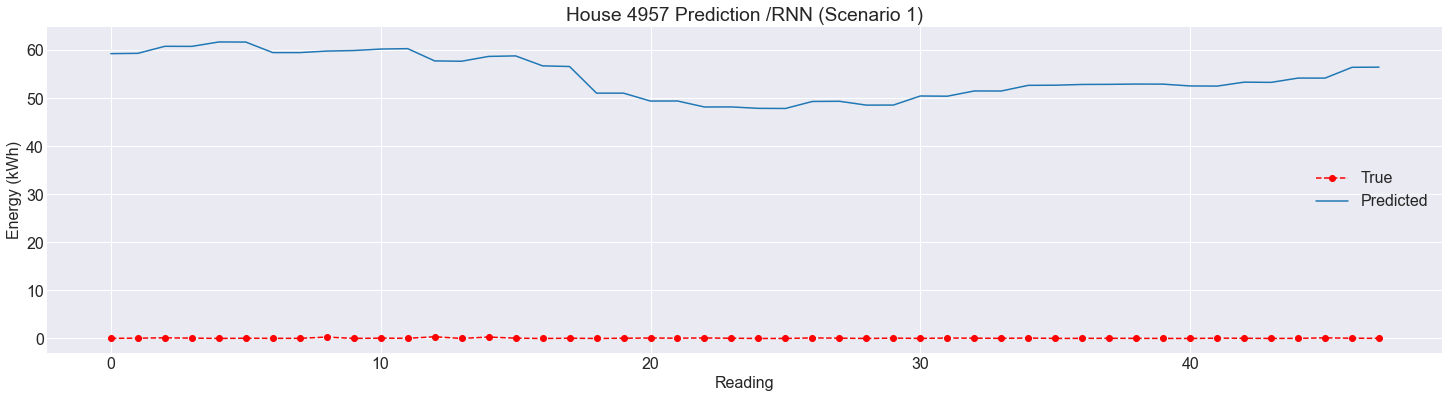

Mse:  18142.860642198418645
Rmse: 134.695436604951169
Mae:  134.666033240190387
Mape:  99.879516752296183


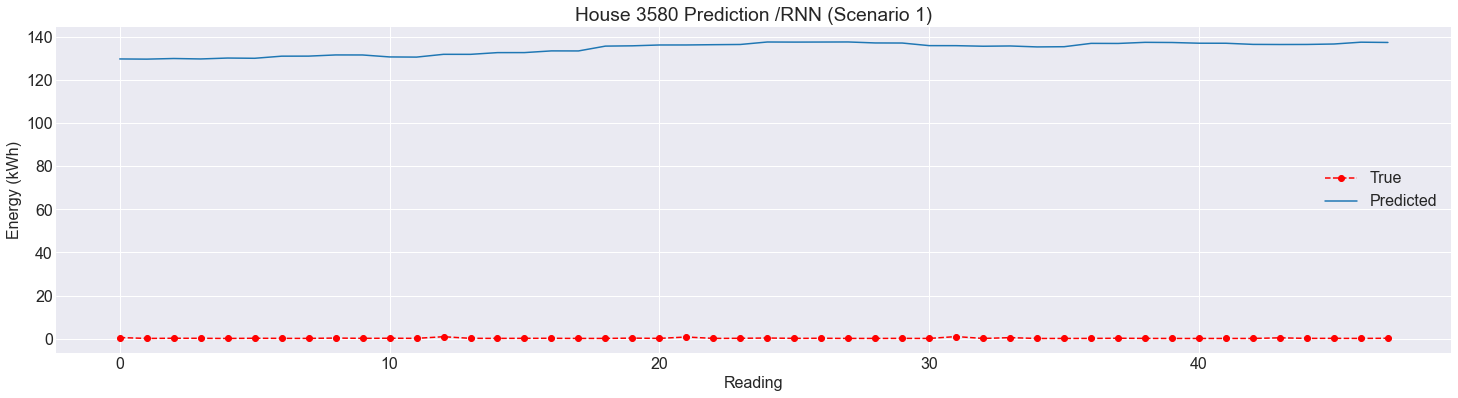

Mse:  1452.614836575825620
Rmse: 38.113184550439044
Mae:  38.103181698437162
Mape:  99.091432820759422


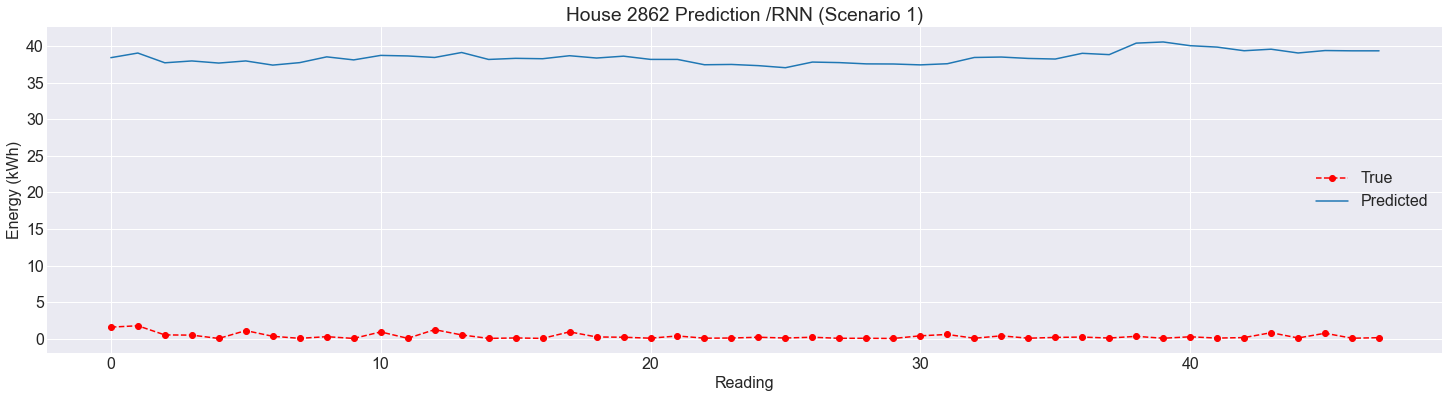

Mse:  6362.538224855631597
Rmse: 79.765520275715815
Mae:  79.723318422756464
Mape:  100.116050726169760


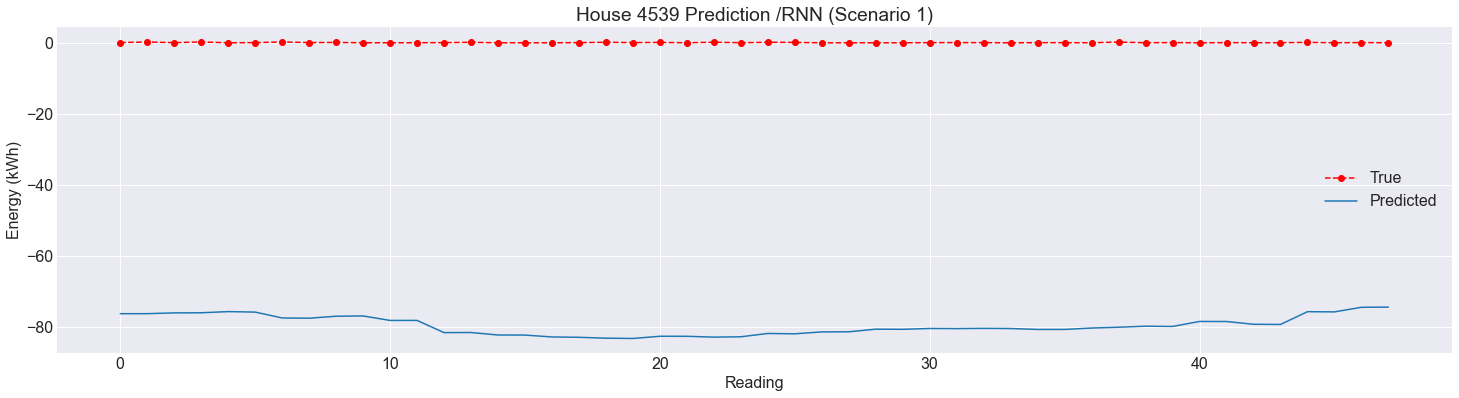

Mse:  21655.839163724853279
Rmse: 147.159230643968954
Mae:  147.136218138543569
Mape:  100.088687436450741


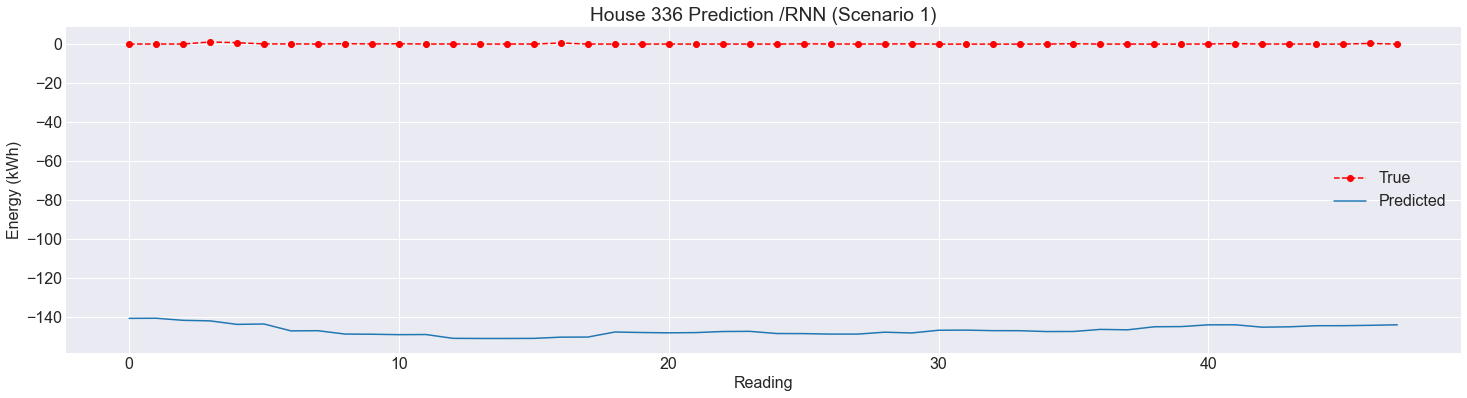

Mse:  1349.317650895711722
Rmse: 36.733059372936957
Mae:  36.695204829331487
Mape:  100.703831266424572


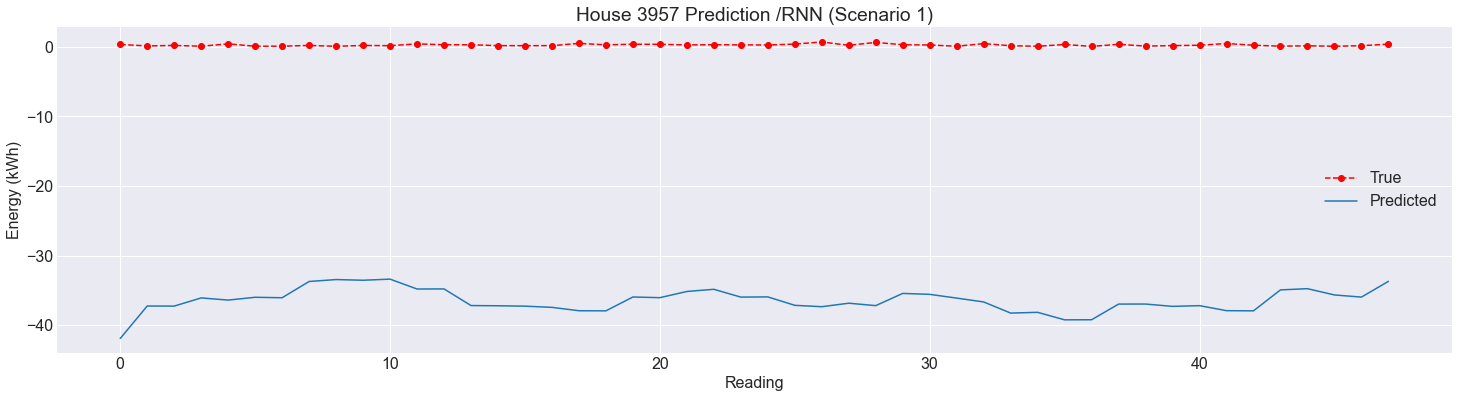

Mse:  5124.111170881199541
Rmse: 71.582897195358058
Mae:  71.570804786092296
Mape:  99.614564715450499


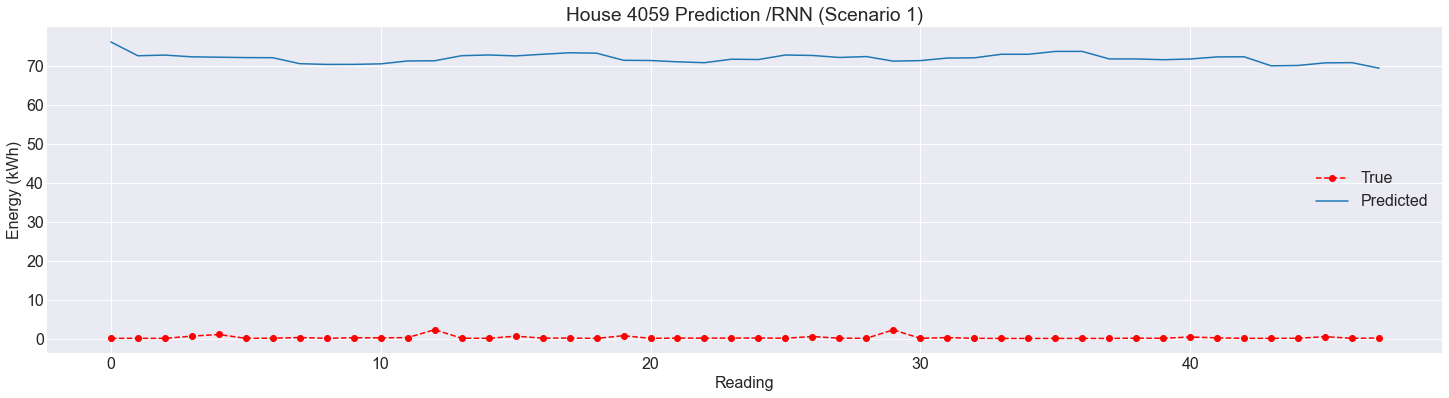

Mse:  35589.358768301390228
Rmse: 188.651421325950764
Mae:  188.648334971182834
Mape:  99.972696031090408


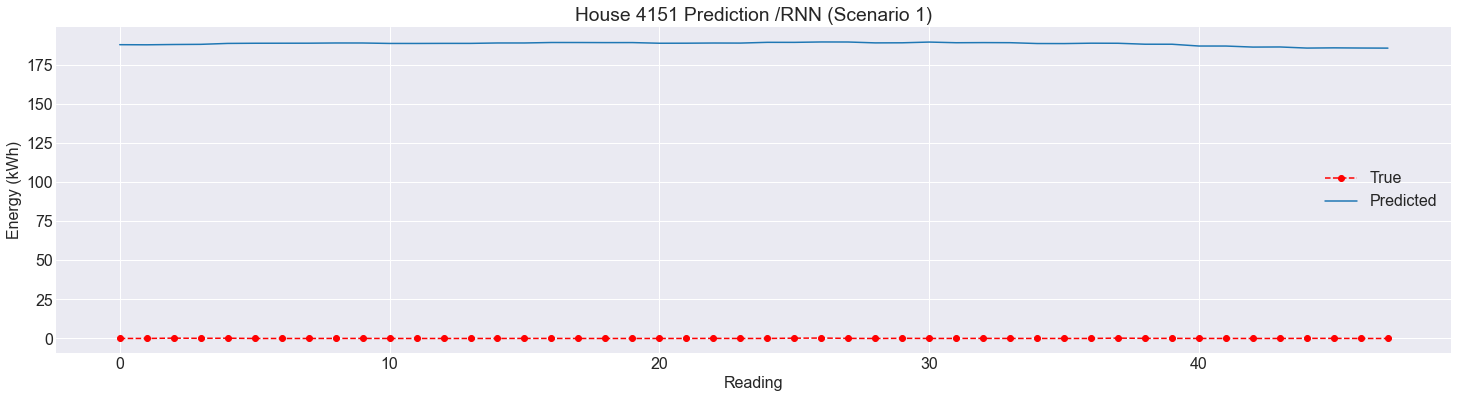

Mse:  6883.173716539102315
Rmse: 82.964894482781702
Mae:  82.913324033686266
Mape:  99.723306382464344


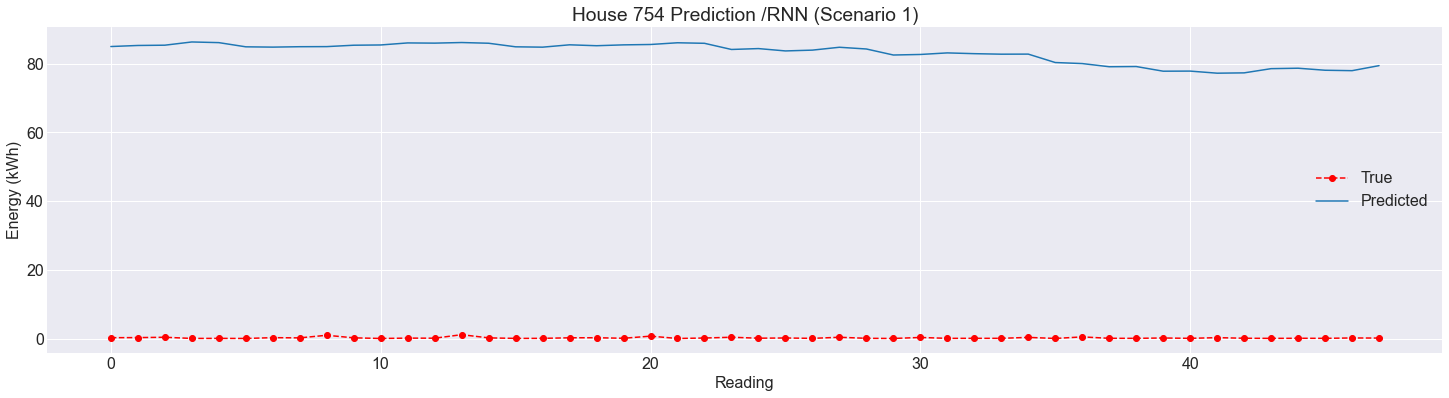

Mse:  4508.040221318831755
Rmse: 67.141940851593134
Mae:  67.110207708882328
Mape:  100.211449150310841


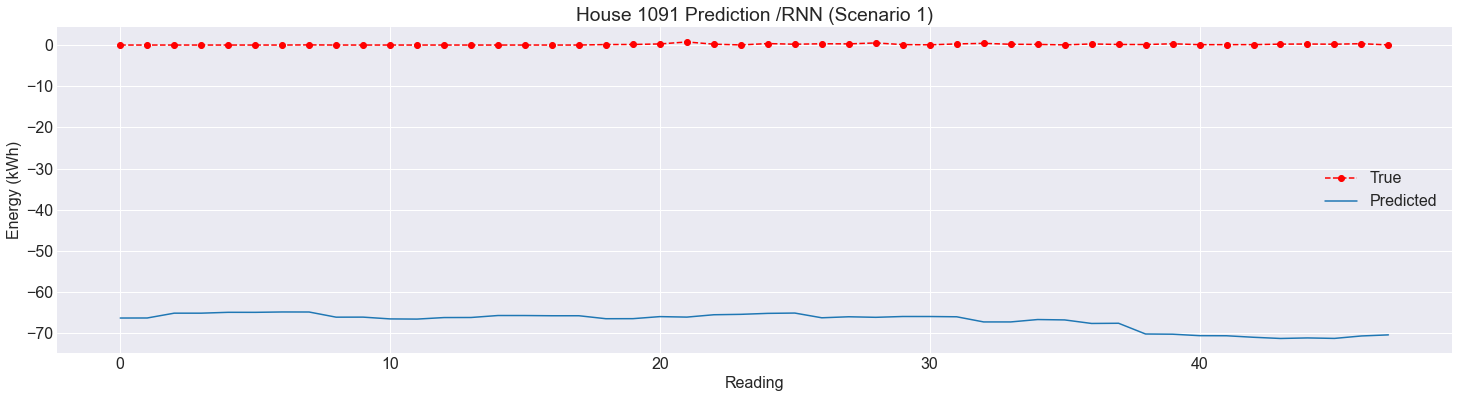

Mse:  12.914419828295925
Rmse: 3.593663844643225
Mae:  3.415408967838933
Mape:  104.320102170321306


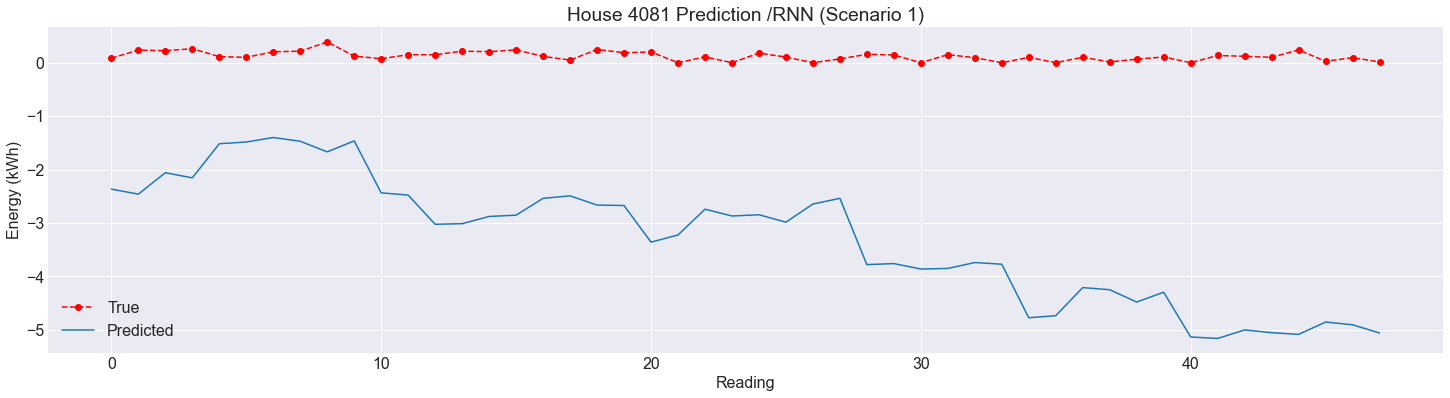

Mse:  17478.400189780793880
Rmse: 132.205900737375543
Mae:  132.203160682537913
Mape:  99.893628058417050


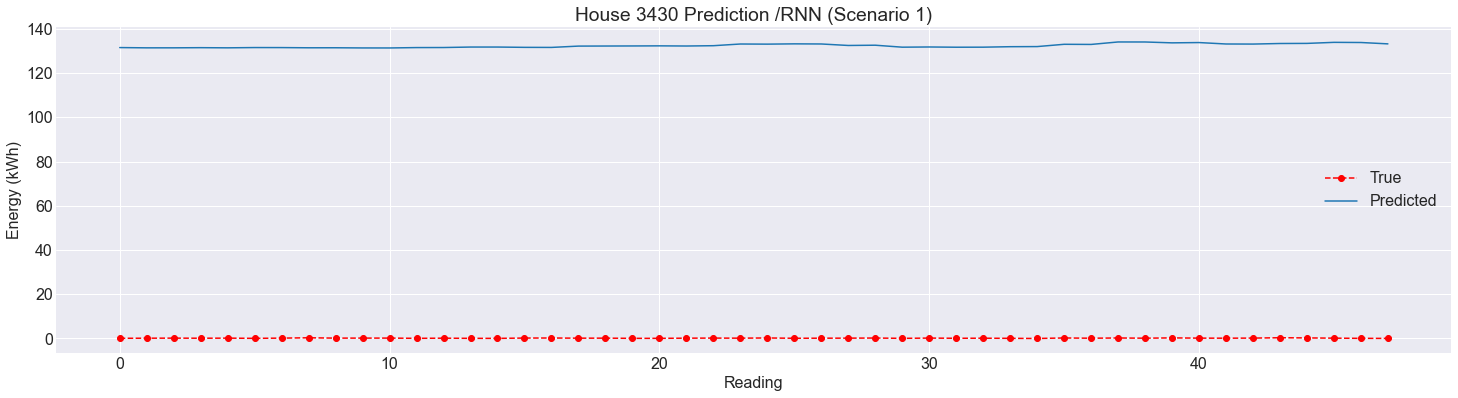

Mse:  4141.077411298830157
Rmse: 64.351203650738583
Mae:  64.335907433958099
Mape:  99.555558690678325


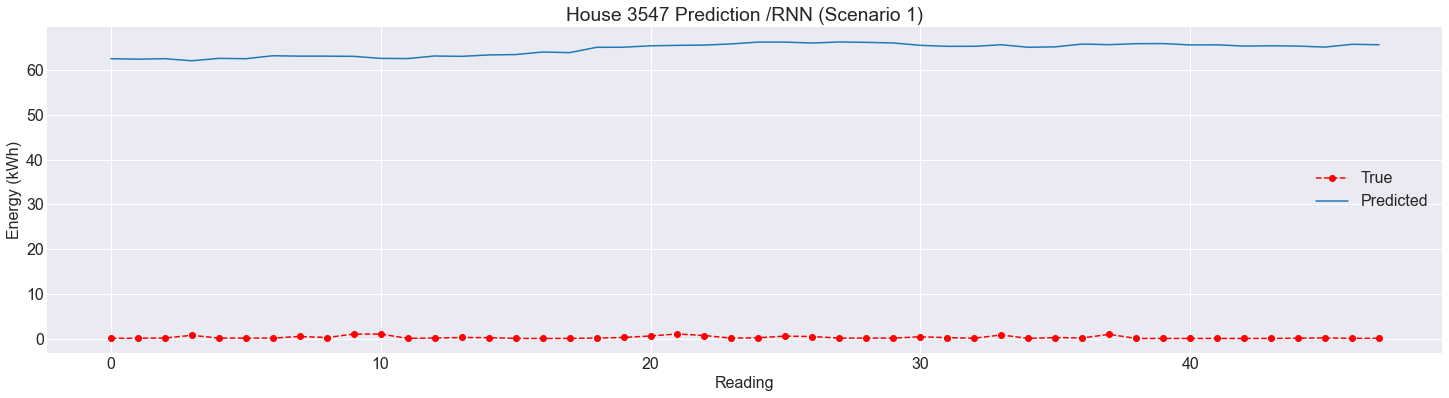

Mse:  21660.323382119109738
Rmse: 147.174465795256452
Mae:  147.146104052973300
Mape:  99.788039472466082


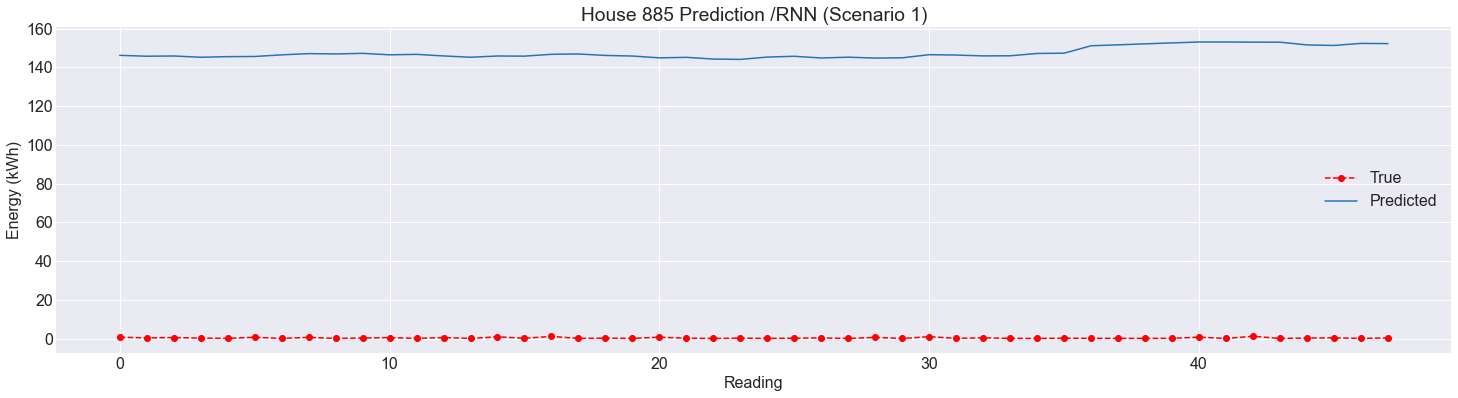

Mse:  2737.231028572824926
Rmse: 52.318553387615992
Mae:  52.271417369600385
Mape:  99.657912169014779


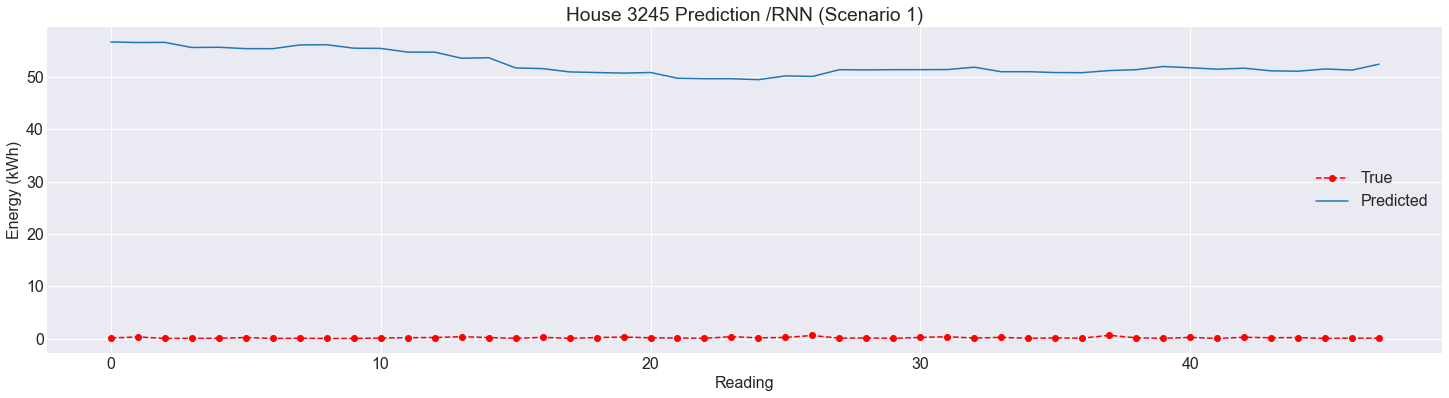

Mse:  3916.343694572598906
Rmse: 62.580697459940467
Mae:  62.558337948905923
Mape:  100.422342539307820


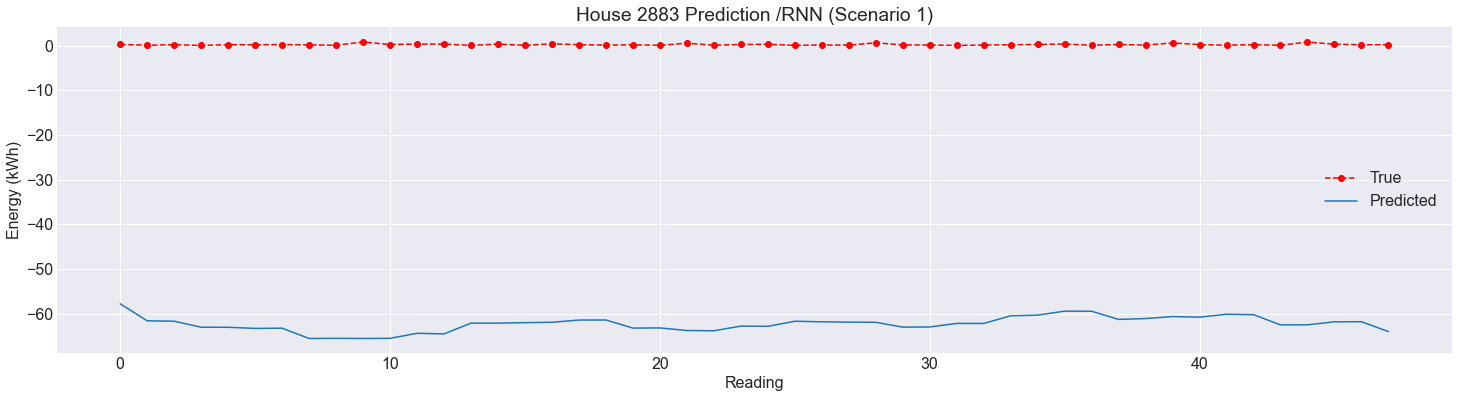

Mse:  7062.694247286482096
Rmse: 84.039837263564962
Mae:  84.002992198608510
Mape:  99.866857243336966


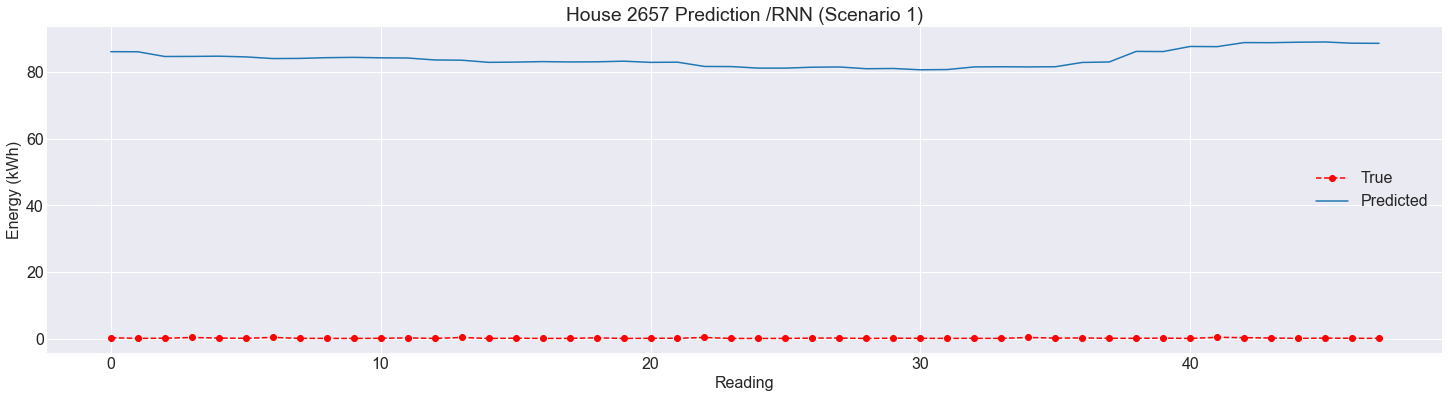

Mse:  13198.295077647926519
Rmse: 114.883832968994923
Mae:  114.811850578446567
Mape:  100.106138988749024


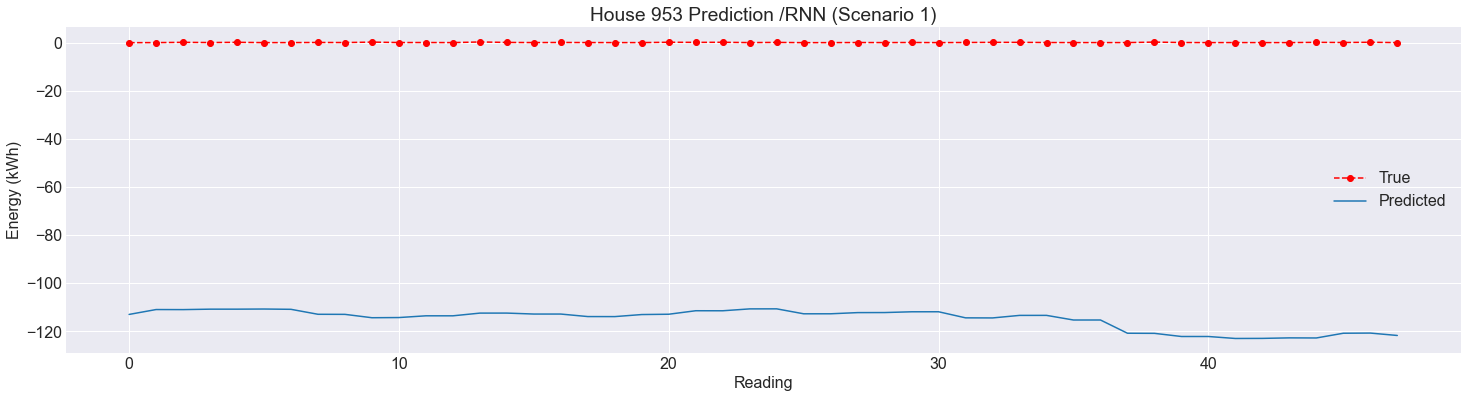

Mse:  64078.228355630730221
Rmse: 253.136777959329180
Mae:  253.061527382582426
Mape:  99.929440522731099


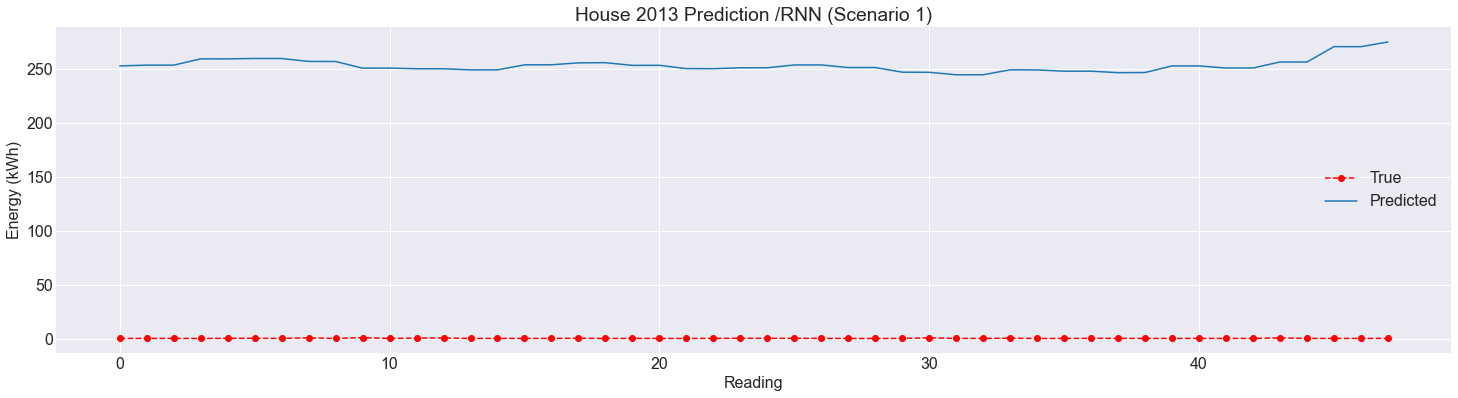

Mse:  32970.630701064910681
Rmse: 181.578166917349705
Mae:  181.576444101015426
Mape:  99.939592550068141


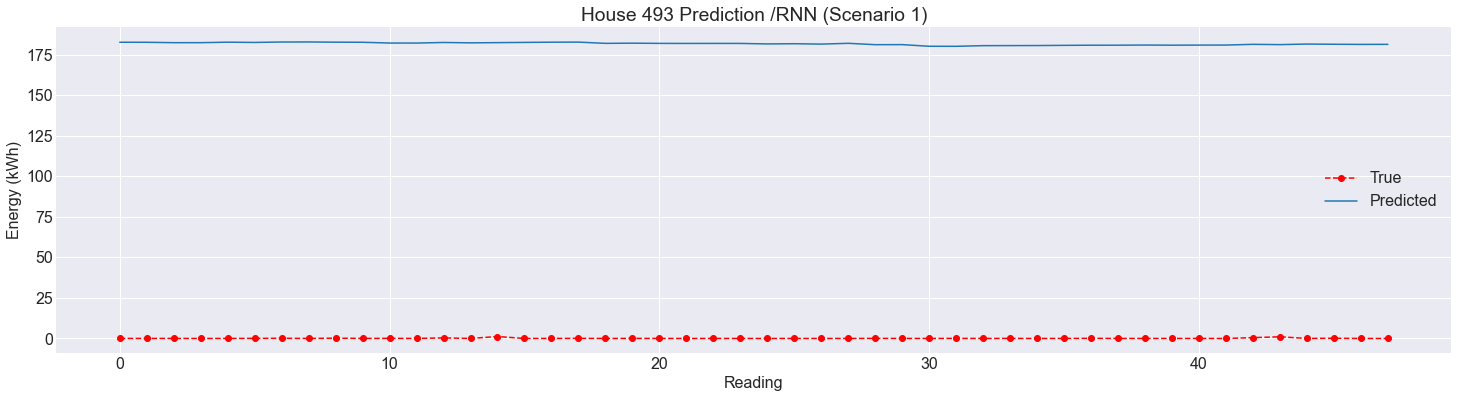

Mse:  2796.137118908357024
Rmse: 52.878512828069937
Mae:  52.875842226669192
Mape:  99.381506113477585


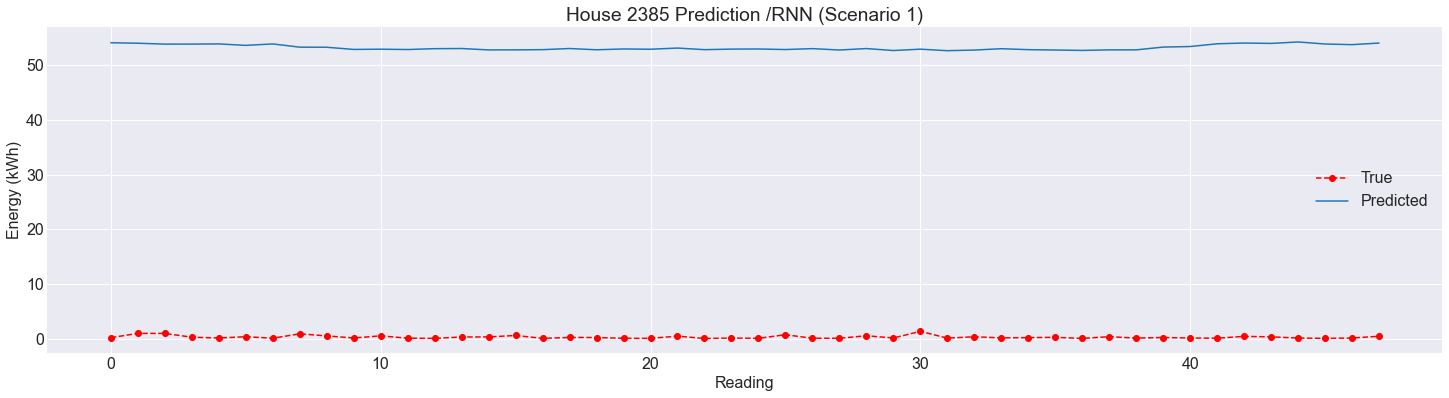

Mse:  19418.686963018302777
Rmse: 139.350948913232401
Mae:  139.348447570965305
Mape:  100.143391622622516


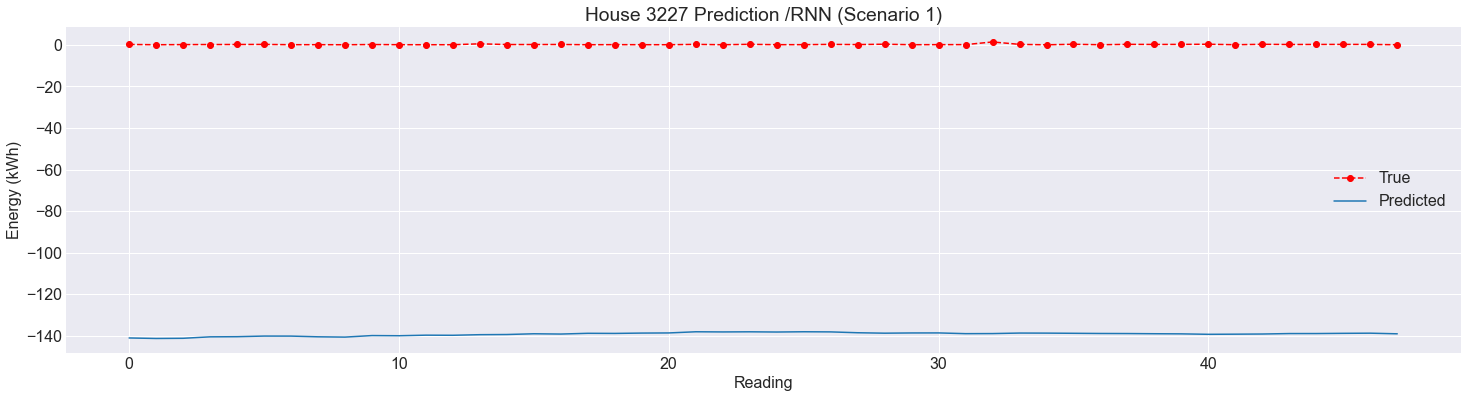

Mse:  1143.715342946699138
Rmse: 33.818860757670400
Mae:  33.324068189521007
Mape:  99.524598408106769


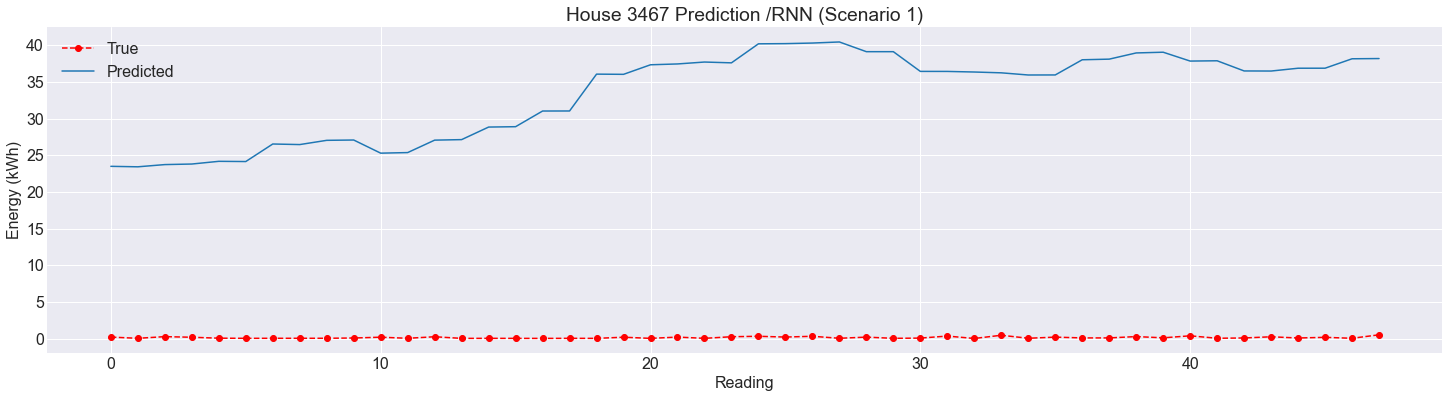

Mse:  61.587577652348756
Rmse: 7.847775331413914
Mae:  7.743537400693943
Mape:  108.284733788510096


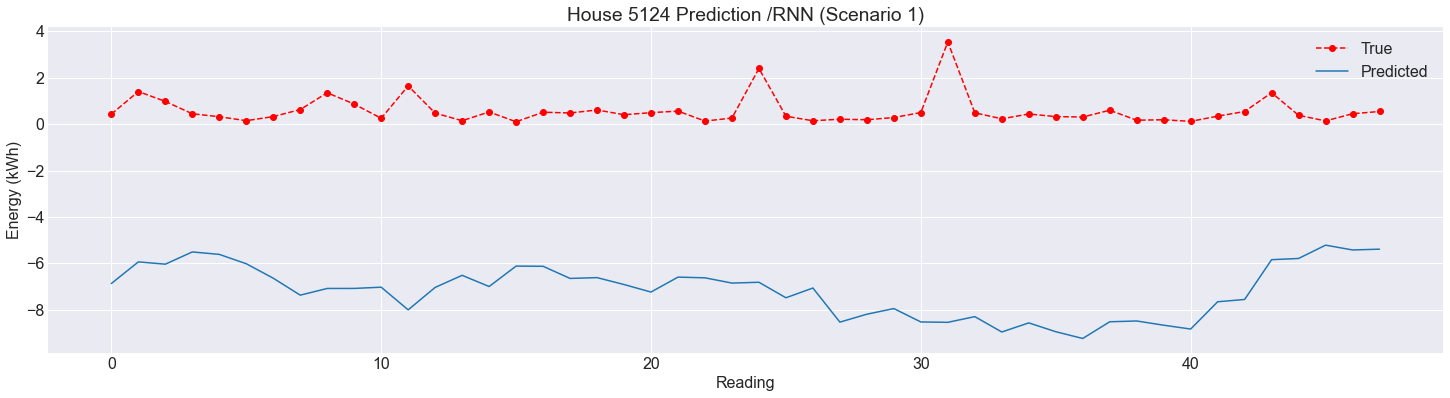

Mse:  15374.922399668859725
Rmse: 123.995654761240971
Mae:  123.990203239644572
Mape:  99.720282070072869


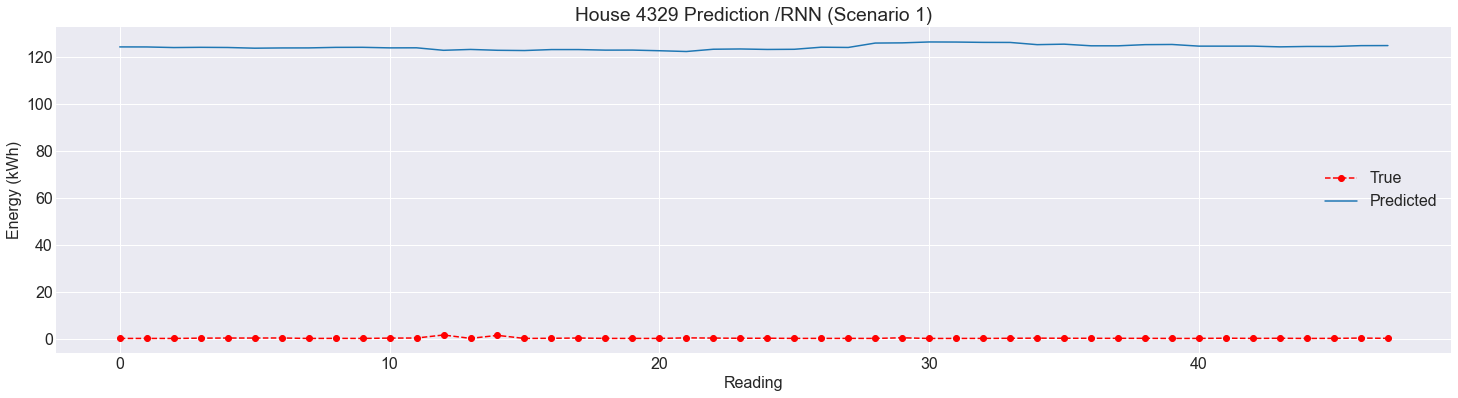

In [134]:
 ##### The households with an error have a '#' 

predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)



In [ ]:
models_performances_HH_level = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level

HH_1         HH_2        HH_3          HH_4  \
MSE_scores   2119.519831  6467.699559  245.403460  60805.529460   
RMSE_scores    46.038243    80.422009   15.665359    246.587772   
MAE_scores     46.036800    80.407101   15.364987    246.430578   
MAPE_scores    99.630134   100.304771   95.472626    100.059374   

                      HH_5        HH_6        HH_7        HH_8         HH_9  \
MSE_scores   109296.546037  136.167222  822.542314  692.737841  2292.052289   
RMSE_scores     330.600281   11.669071   28.679998   26.319913    47.875383   
MAE_scores      330.495861   11.039999   28.668951   26.237959    47.858832   
MAPE_scores     100.019513  101.788689   98.795460   99.647155    99.728216   

                  HH_10  ...        HH_20         HH_21         HH_22  \
MSE_scores   246.306776  ...  2138.524425  16112.381694  95719.444332   
RMSE_scores   15.694164  ...    46.244183    126.934557    309.385592   
MAE_scores    15.487724  ...    46.238916    126.932922    309.372861   
MAPE_scores  101.731604  ...   100.571994     99.911922     99.960712   

                   HH_23        HH_24        HH_25        HH_26         HH_27  \
MSE_scores   7830.711347  5515.074241  8392.249229  1767.361197  28968.058277   
RMSE_scores    88.491307    74.263546    91.609220    42.039995    170.200054   
MAE_scores     88.484838    74.214993    91.605457    41.976768    170.075806   
MAPE_scores    99.798555   100.148297   100.360513    99.525443     99.909521   

                   HH_28         HH_29  
MSE_scores   5881.127080  10117.097933  
RMSE_scores    76.688507    100.583786  
MAE_scores     76.660880    100.575105  
MAPE_scores   100.762050     99.655361  

[4 rows x 29 columns]

In [ ]:
models_performances_HH_level.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario1.csv', index=False)

In [ ]:
## Best regression model

In [135]:
MSE_scores_HH = []
RMSE_scores_HH = []
MAE_scores_HH = []
MAPE_scores_HH = []
households_predictions = ['HH_1',
                      'HH_2',
                      'HH_3',
                      'HH_4',
                      'HH_5',
                      'HH_6',
                      'HH_7',
                      'HH_8',
                      'HH_9',
                      'HH_10',
                      'HH_11',
                      'HH_12',
                      'HH_13',
                      'HH_14',
                      'HH_15',
                      'HH_16',
                      'HH_17',
                      'HH_18',
                      'HH_19',
                      'HH_20',
                      'HH_21',
                      'HH_22',
                      'HH_23',
                      'HH_24',
                      'HH_25',
                      'HH_26',
                      'HH_27',
                      'HH_28', 
                      'HH_29']

In [136]:
# tune the Rf parametersbegining with house numbber of your choice 
def predict_household_AfterTuning(num):
  house = updated_houses[updated_houses.LCLid==num]

  np.random.seed(5)
  dataframe = house.loc[:,'energy(kWh/hh)']
  dataset = dataframe.values
  dataset = dataset.astype('float32')

  reframed = series_to_supervised(dataset, 24,1)

  # Select required columns and merge with supervised data
  df=house[weather_energy.columns[1:]]
  df = df[12:]
  reframed = pd.concat([df, reframed], axis=1).dropna()

  reframed = reframed.reindex(reframed.columns, axis=1)
  reframed = reframed.values

  # split into train and test sets''''
  train = reframed[:(len(reframed)-48), :]
  test = reframed[(len(reframed)-48):len(reframed), :]

  #test_X, labels = test[:, :-1], test[:, -1]
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]


  model = LinearSVR(C=8, 
                  dual=False, 
                  epsilon=0.001, loss='squared_epsilon_insensitive') 
  model.fit(train_X, train_y)

  predicted = model.predict(test_X)

  mse_HH = mean_squared_error(predicted,test_y.ravel())
  rmse_HH = mean_squared_error(predicted,test_y.ravel(), squared=False)
  mae_HH = mean_absolute_error(predicted,test_y.ravel())
  mape_HH = mean_absolute_percentage_error(predicted, test_y.ravel())

  print(f'Mse:  {mse_HH:.15f}')
  print(f'Rmse: {rmse_HH:.15f}')
  print(f'Mae:  {mae_HH:.15f}')
  print(f'Mape:  {mape_HH:.15f}')
  #print(f'Training time: {train_time_HH:.3f} s') 

  MSE_scores_HH.append(mse_HH)
  RMSE_scores_HH.append(rmse_HH)
  MAE_scores_HH.append(mae_HH)
  MAPE_scores_HH.append(mape_HH)
#  train_times_HH.append(train_time)

  matplotlib.rcParams.update({'font.size': 16})
  predicted_house = pd.DataFrame({'Predicted':predicted.ravel(),'True Reading':test_y.ravel()})
  predicted_house['True Reading'].plot(figsize=(25,6), linestyle='--', marker='o', color='red')
  predicted_house['Predicted'].plot()
  plt.title(f'House {num} Prediction /SVR')
  plt.xlabel('Reading')
  plt.ylabel('Energy (kWh)')
  # style

  plt.style.use('seaborn-darkgrid')
  palette = plt.get_cmap('Set1')

  plt.grid(b=True, which='major', color='w', linewidth=1.0)
  plt.legend(['True','Predicted'])
  plt.savefig('C:/JET/Masterarbeit/_Masterarbeit_FlashMemory/4_plots_computed/Scenario1/2_singleHouseholdLevel/best_regression_model/S1_24h_SVR_HH'+str(num) + '.jpeg', dpi = 500)
  plt.show()


Mse:  0.019331474999964
Rmse: 0.139037674750279
Mae:  0.094005953959919
Mape:  312.100443932373423


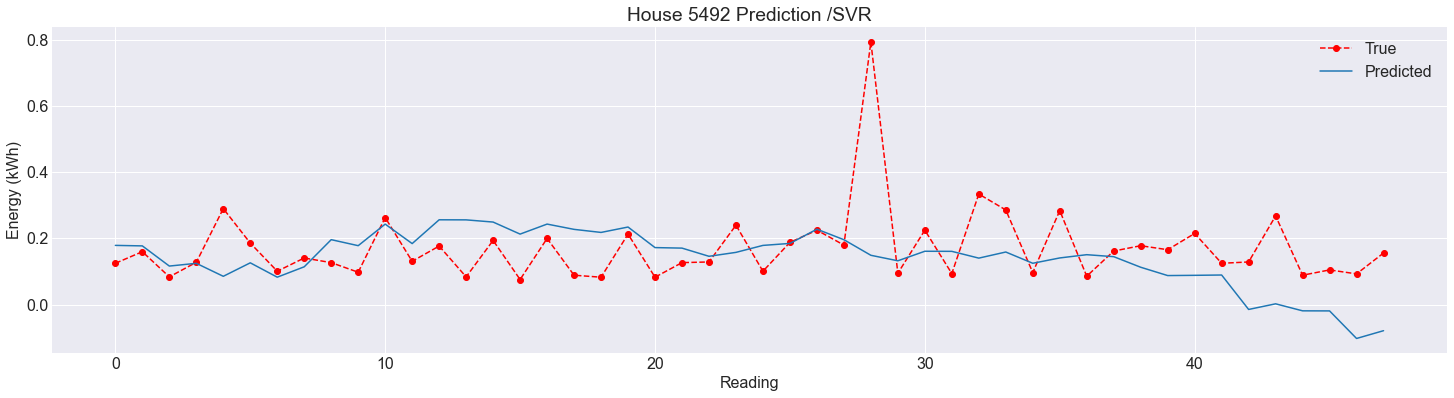

Mse:  0.138496189237518
Rmse: 0.372150761436166
Mae:  0.303844354570099
Mape:  265.115416098066817


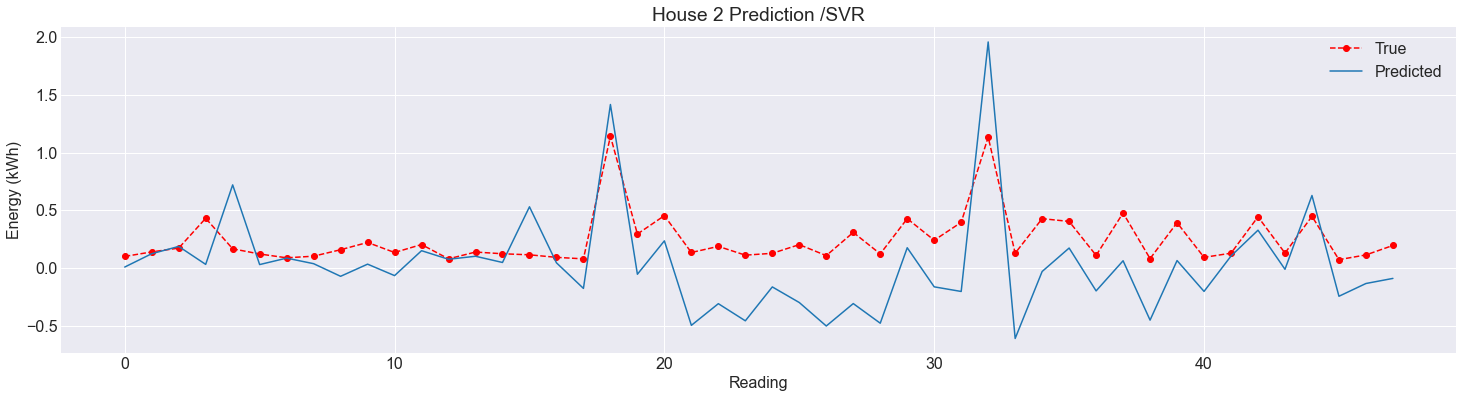

Mse:  0.202404054423528
Rmse: 0.449893381173282
Mae:  0.303247230533663
Mape:  75.357679809093597


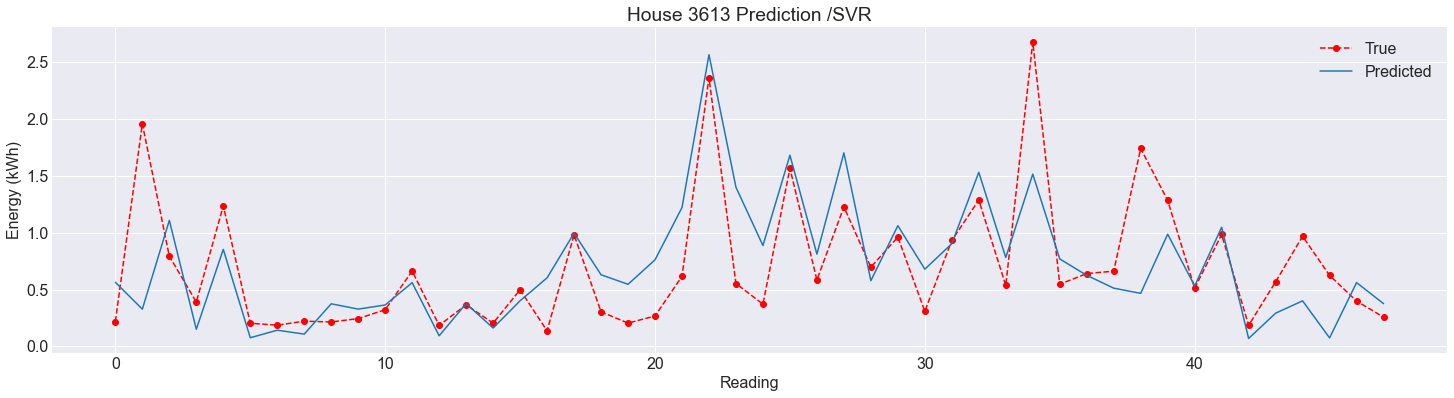

Mse:  0.028310315219377
Rmse: 0.168256694426632
Mae:  0.099706037369189
Mape:  158.113140432050216


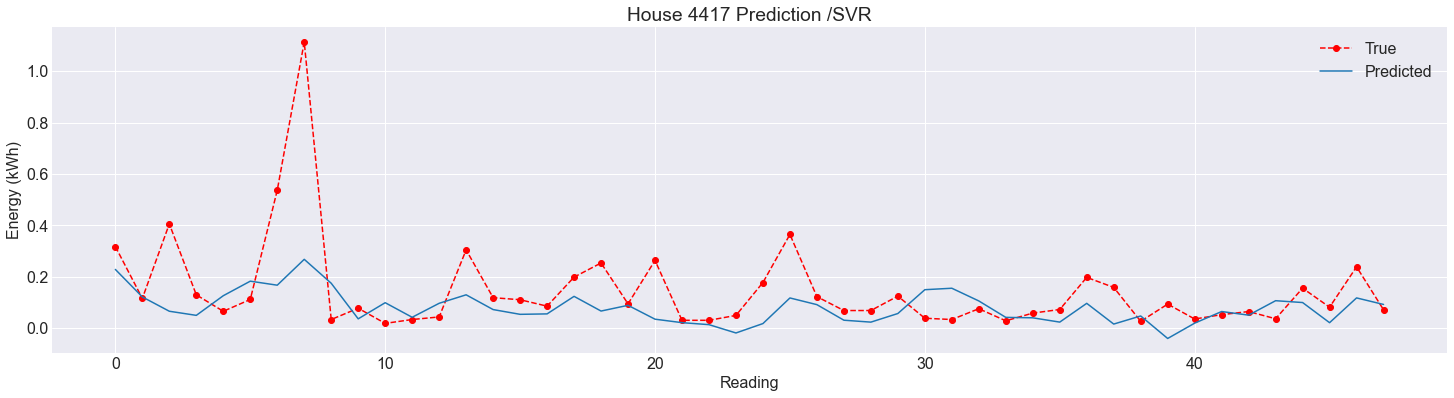

Mse:  0.005447543372893
Rmse: 0.073807475047535
Mae:  0.044319193937482
Mape:  92.645452240959671


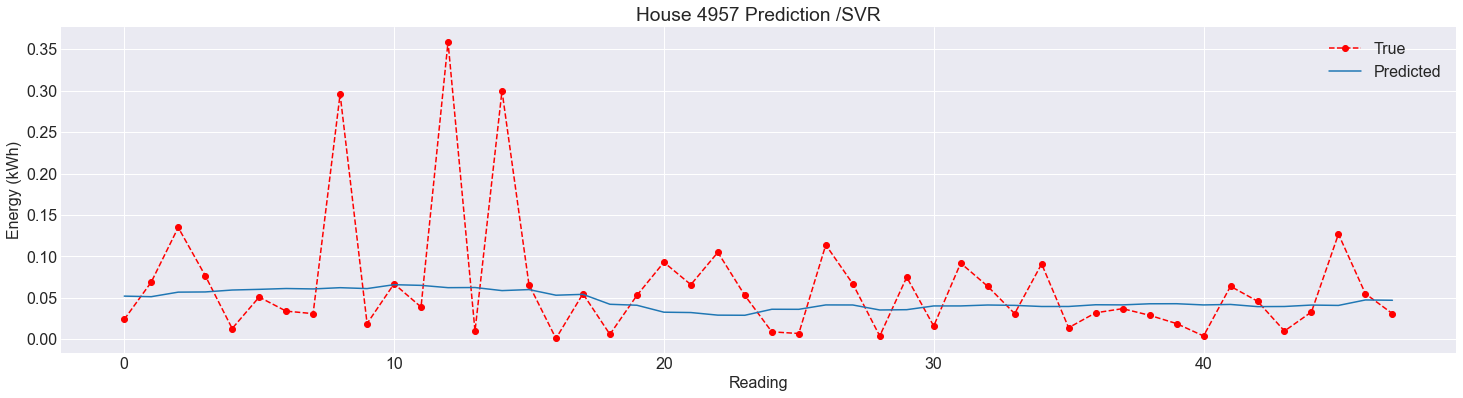

Mse:  0.043771404302083
Rmse: 0.209216166445336
Mae:  0.104868929943943
Mape:  854.128293801846326


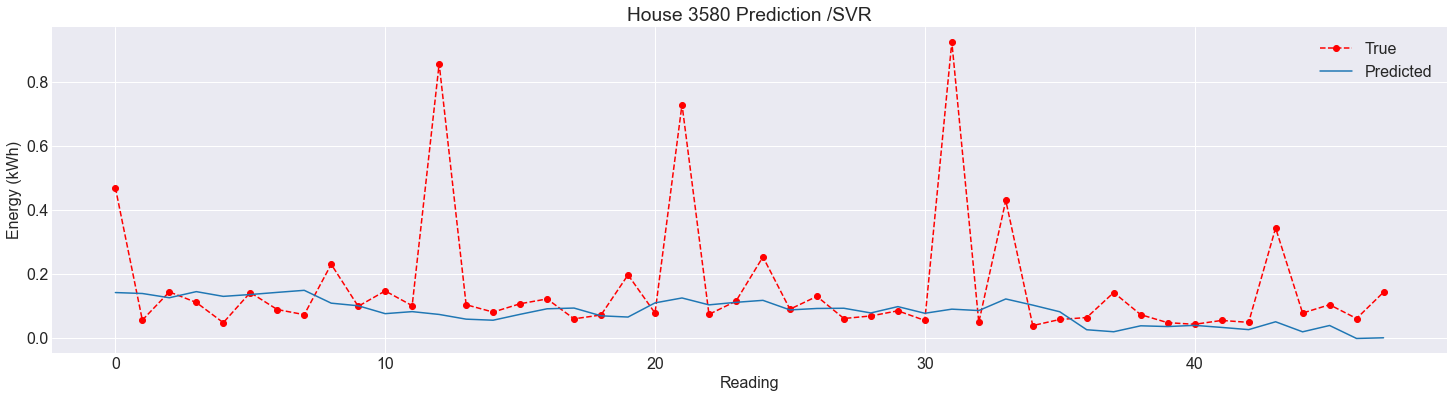

Mse:  0.284862386279644
Rmse: 0.533725009981399
Mae:  0.468613515142571
Mape:  503.027613909009233


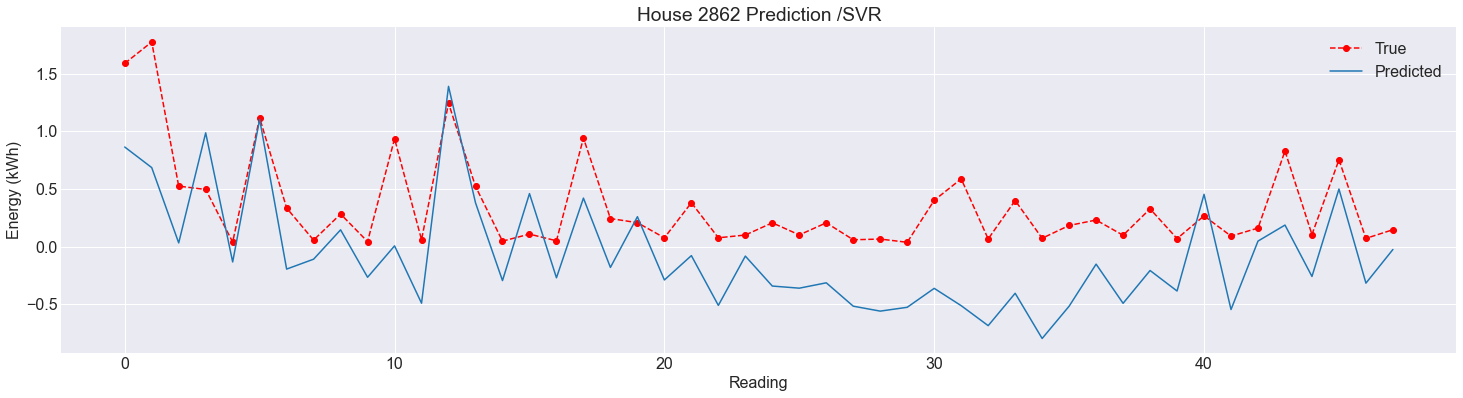

Mse:  0.005022383298683
Rmse: 0.070868775202364
Mae:  0.061760878724628
Mape:  49.725685544848979


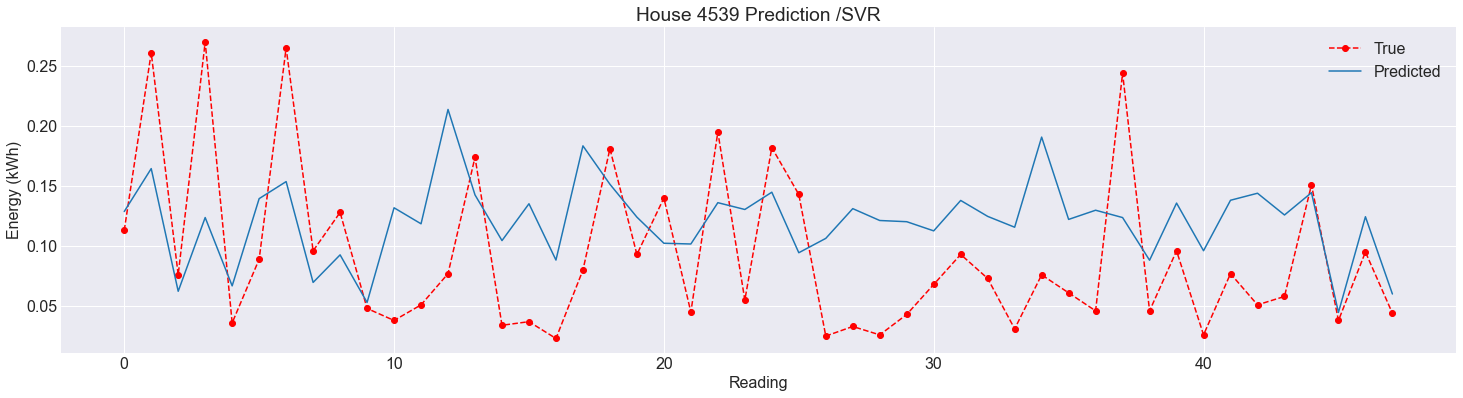

Mse:  0.209377252870873
Rmse: 0.457577592186148
Mae:  0.326316452251860
Mape:  145.388104048699404


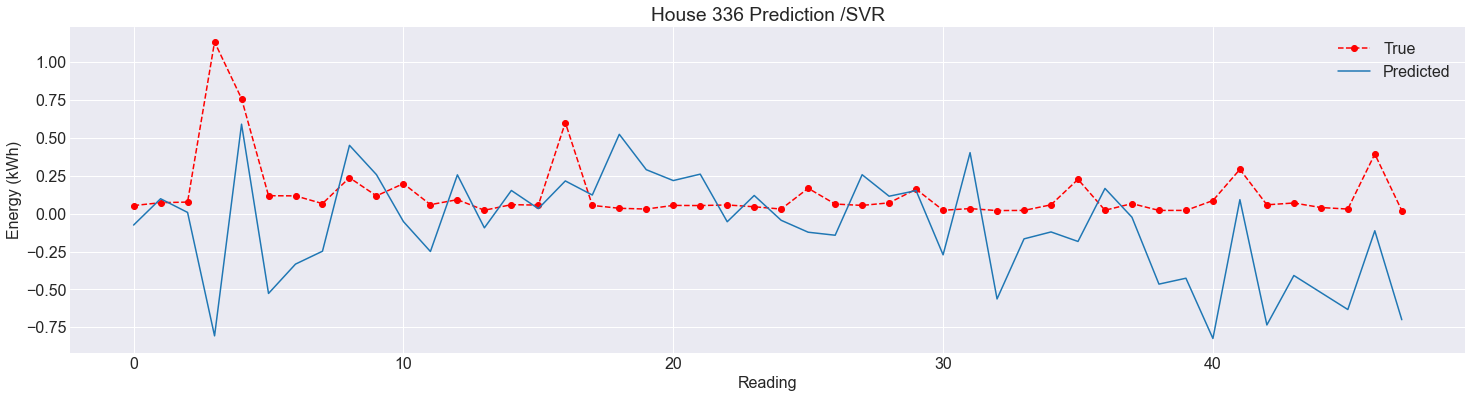

Mse:  0.081525717186197
Rmse: 0.285527086606852
Mae:  0.244797716352273
Mape:  1157.808909282865443


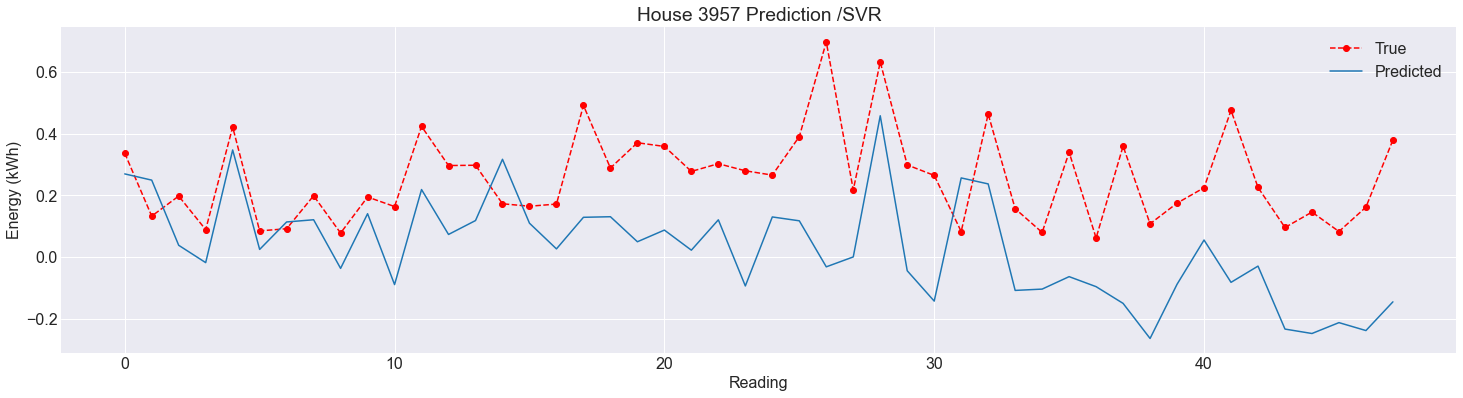

Mse:  0.229613896853717
Rmse: 0.479180442895698
Mae:  0.371332122801430
Mape:  110.999035048832638


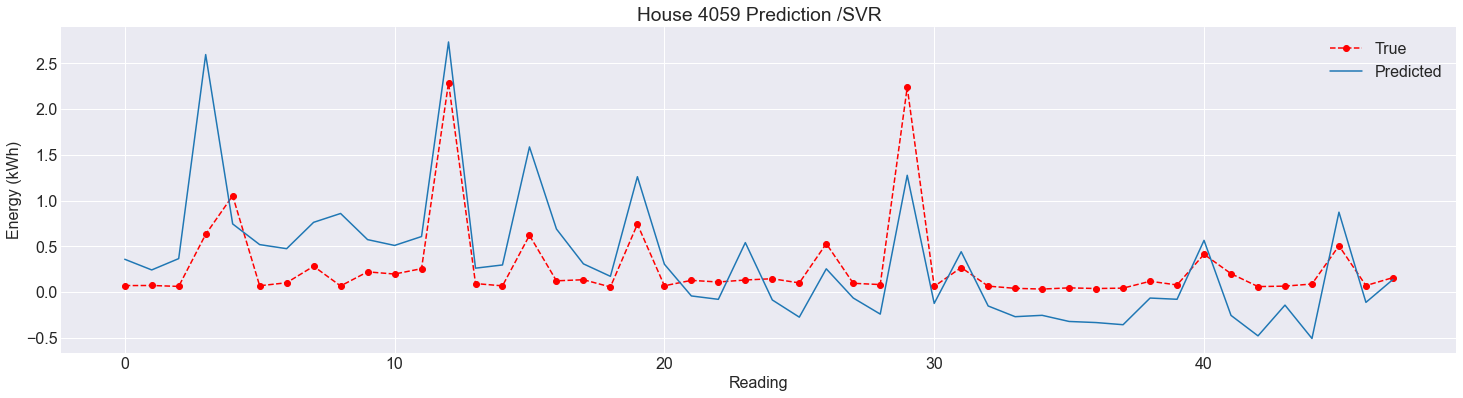

Mse:  0.011072811226300
Rmse: 0.105227426207714
Mae:  0.094418545548557
Mape:  74.046268259208915


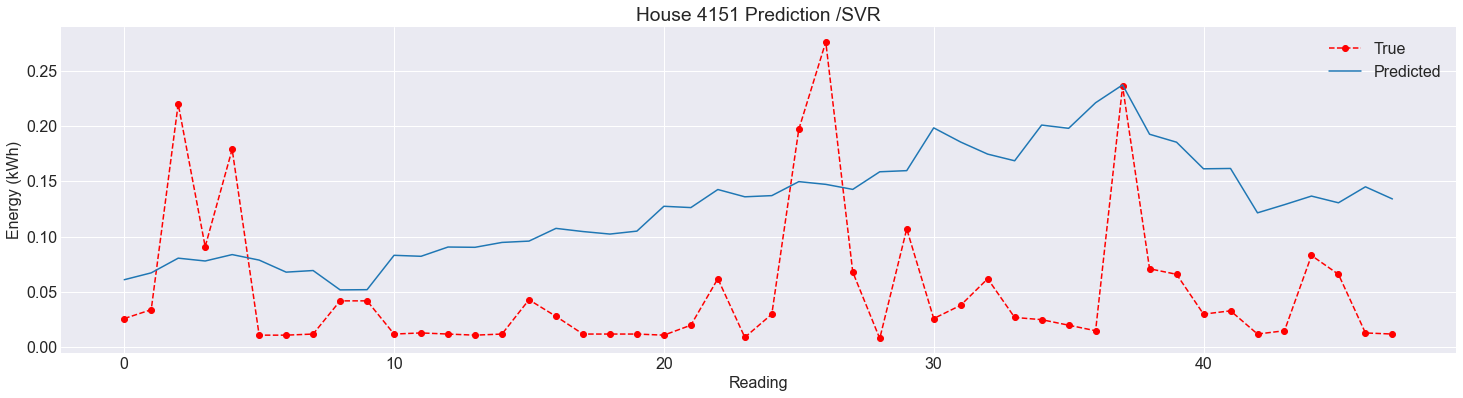

Mse:  0.585427340455154
Rmse: 0.765132237234293
Mae:  0.640314537972630
Mape:  75.307409081303774


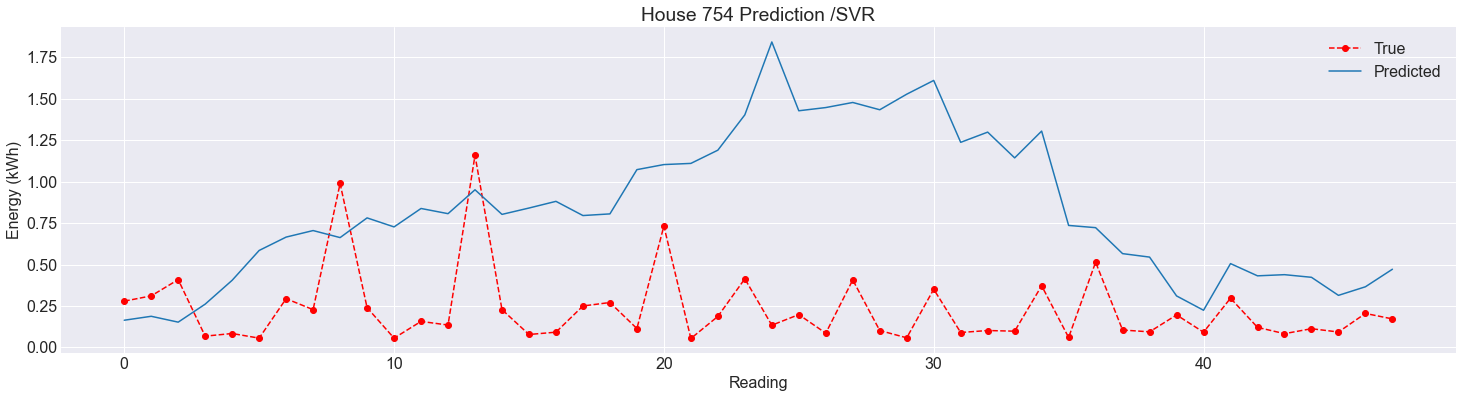

Mse:  0.039916321218522
Rmse: 0.199790693523302
Mae:  0.159051460501546
Mape:  72.669209328435201


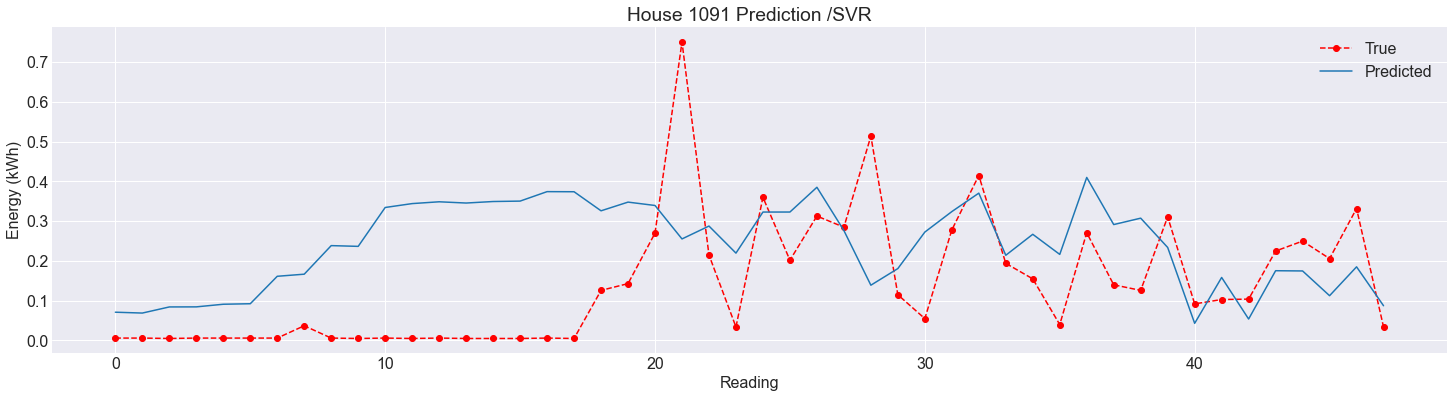

Mse:  0.010164809985665
Rmse: 0.100820682330886
Mae:  0.088152167382420
Mape:  48.416210825780595


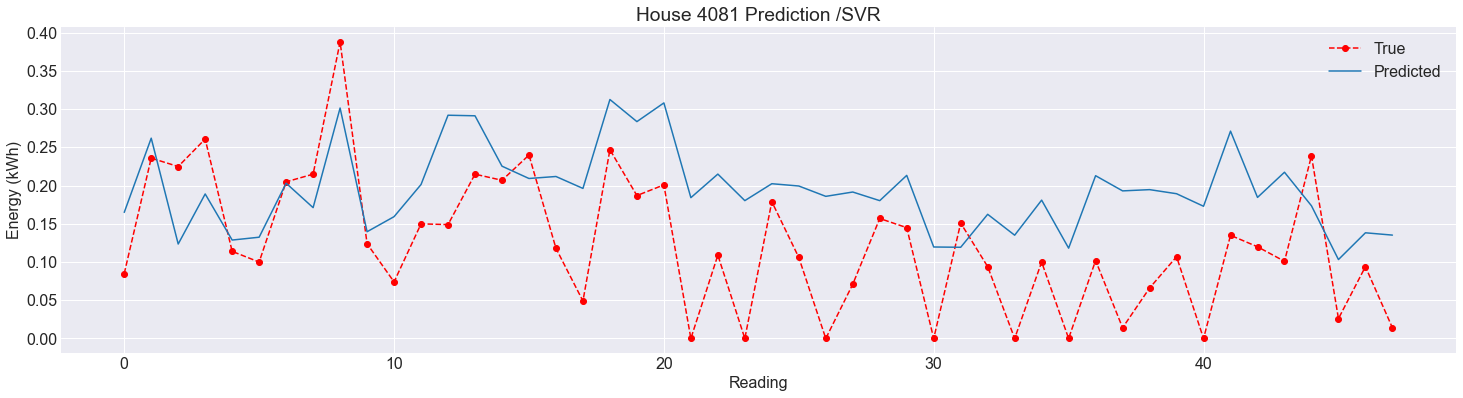

Mse:  0.032770435569087
Rmse: 0.181026063231478
Mae:  0.165314894462414
Mape:  432.181609766962538


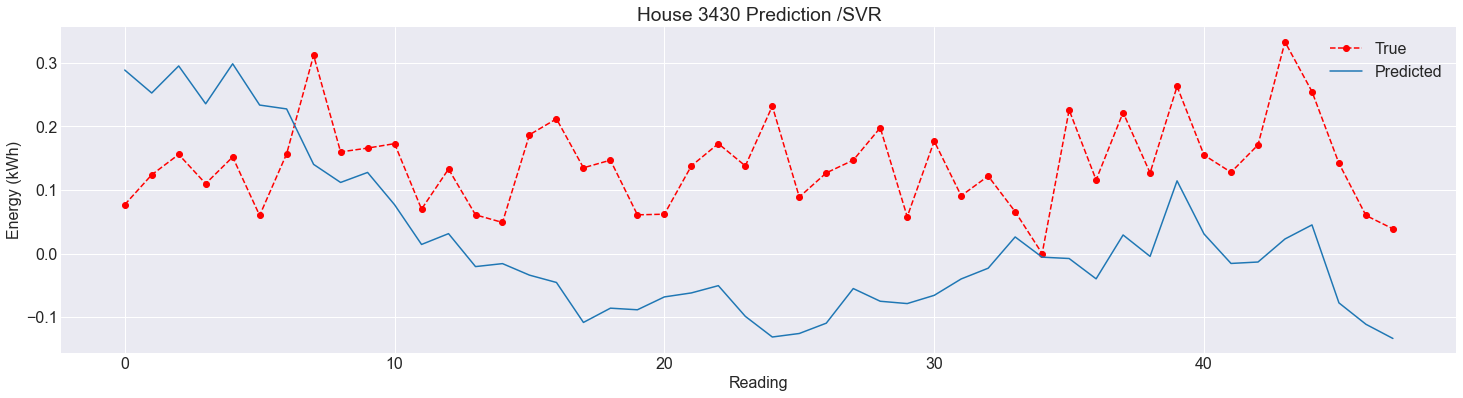

Mse:  0.220182171077825
Rmse: 0.469235730819622
Mae:  0.334801541212762
Mape:  248.252043666087815


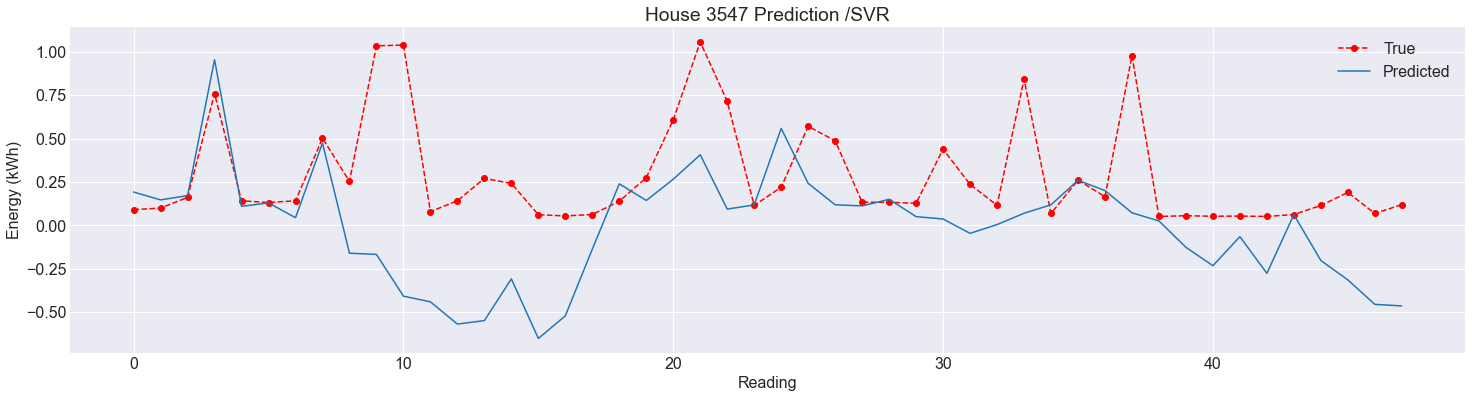

Mse:  0.419147493782699
Rmse: 0.647416012918046
Mae:  0.512297218918091
Mape:  363.097933505818219


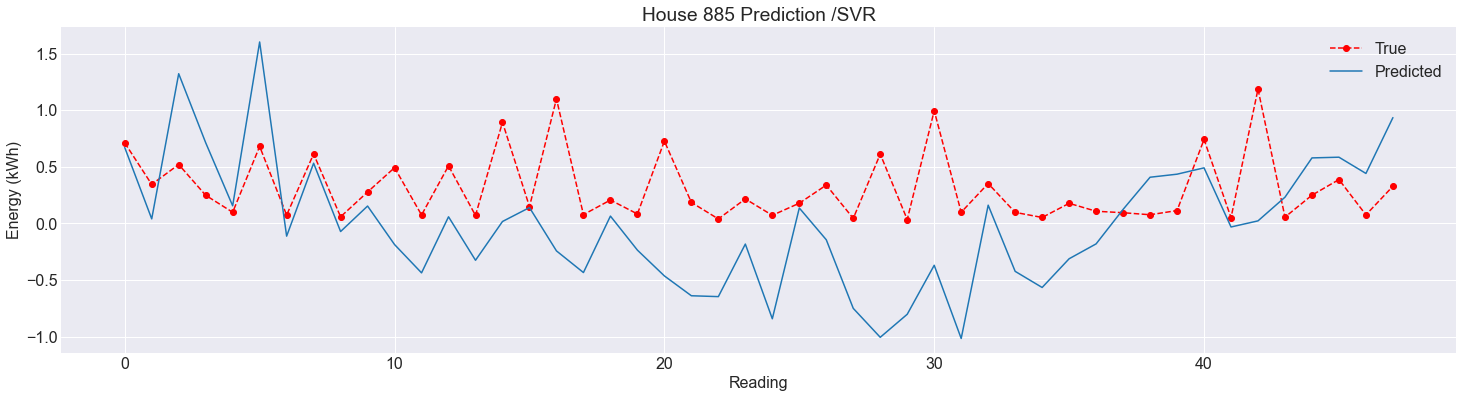

Mse:  0.031625653907813
Rmse: 0.177836030960582
Mae:  0.140051926150344
Mape:  177.480224246802635


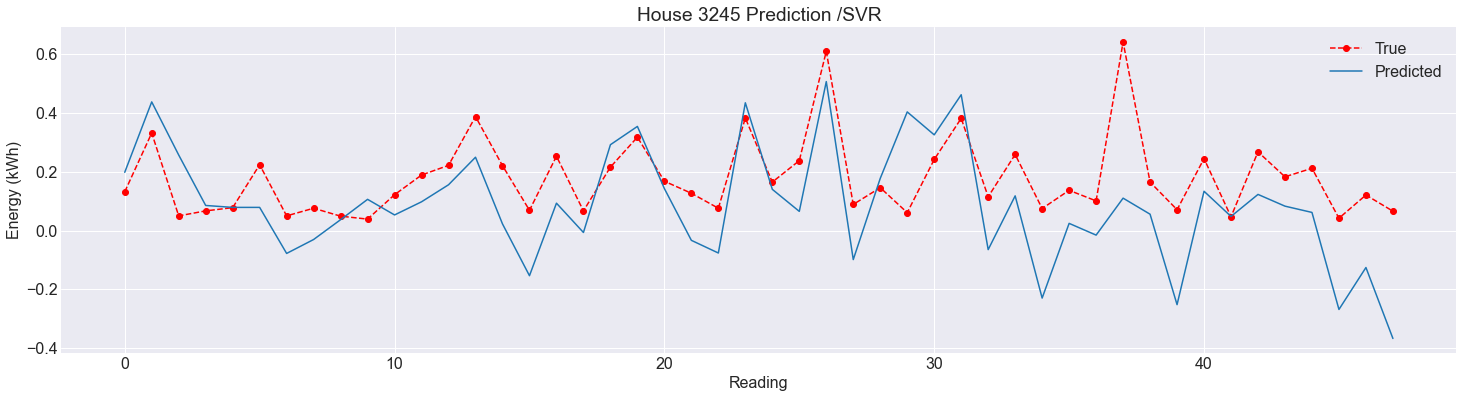

Mse:  0.056944197123049
Rmse: 0.238629832843777
Mae:  0.173587338692500
Mape:  490.406901245561130


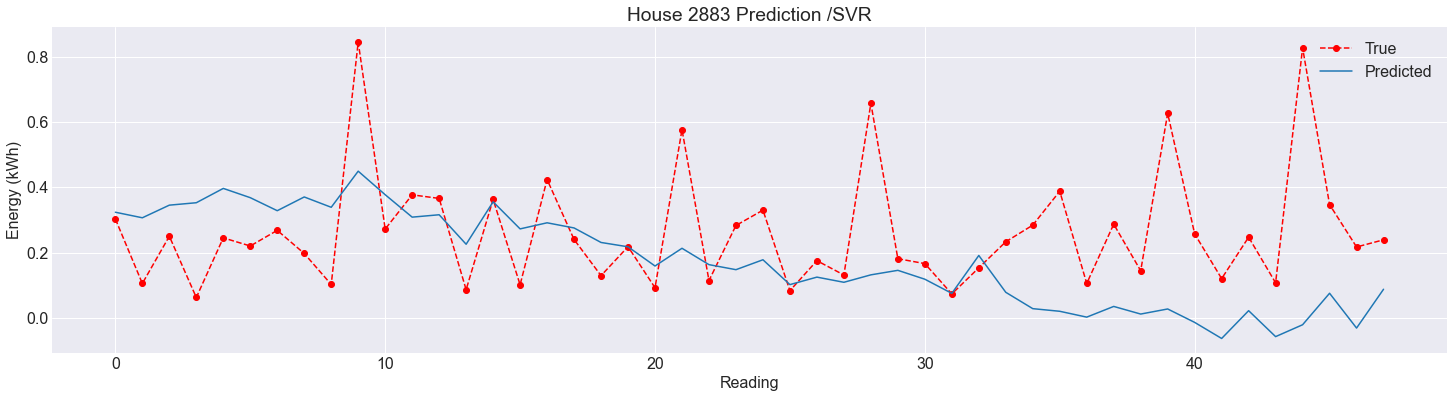

Mse:  0.065403385559794
Rmse: 0.255740856258428
Mae:  0.228153732025381
Mape:  66.796993024558759


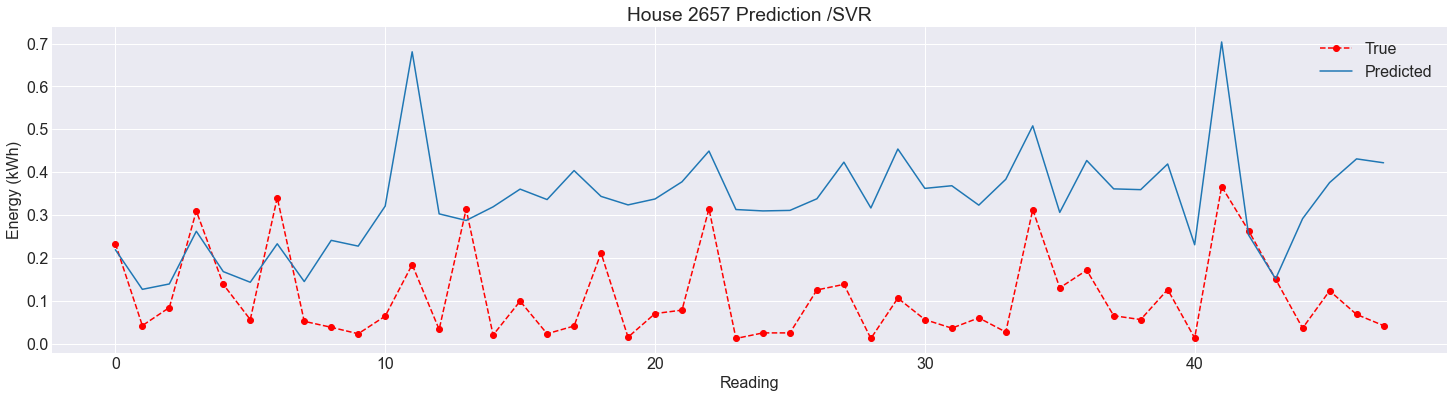

Mse:  0.004409546664651
Rmse: 0.066404417508556
Mae:  0.055946484448541
Mape:  41.915926709497626


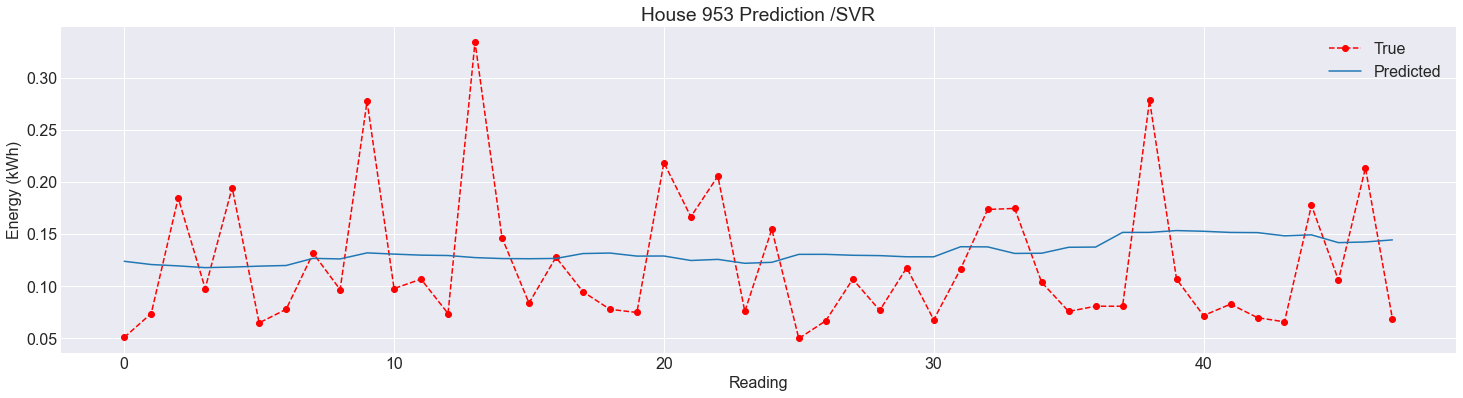

Mse:  0.090841239977268
Rmse: 0.301398805533911
Mae:  0.244821640422832
Mape:  935.791575683501037


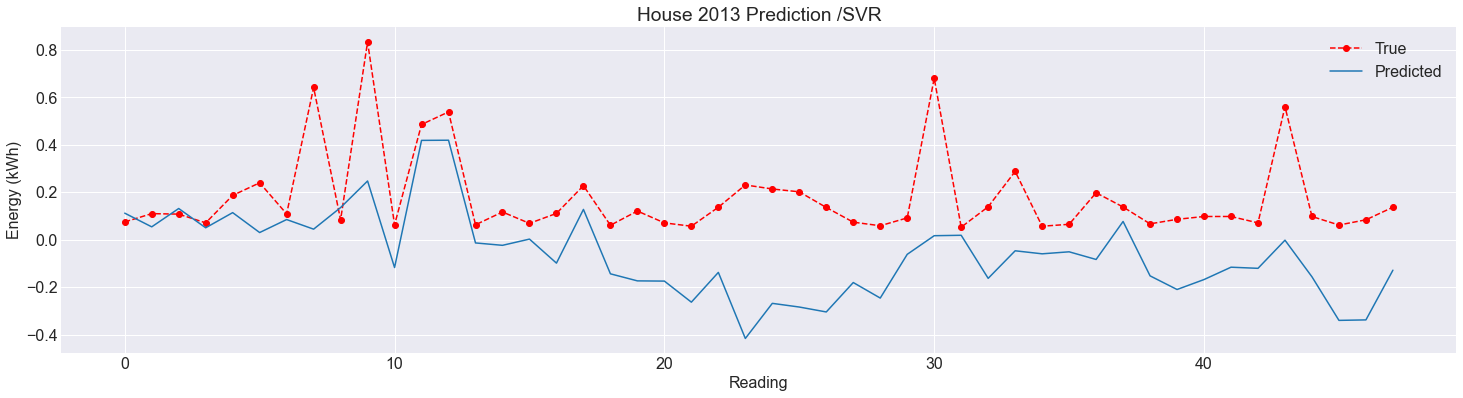

Mse:  0.049721470014261
Rmse: 0.222983115984734
Mae:  0.106314046718844
Mape:  1407.224394252069033


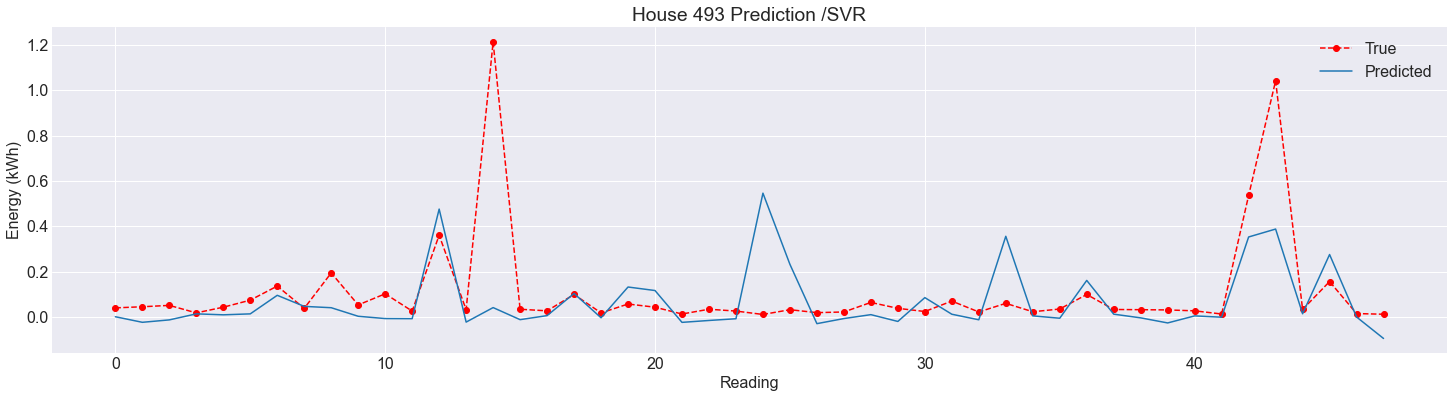

Mse:  0.064955058955930
Rmse: 0.254862823801216
Mae:  0.169487591225158
Mape:  129701.800513922382379


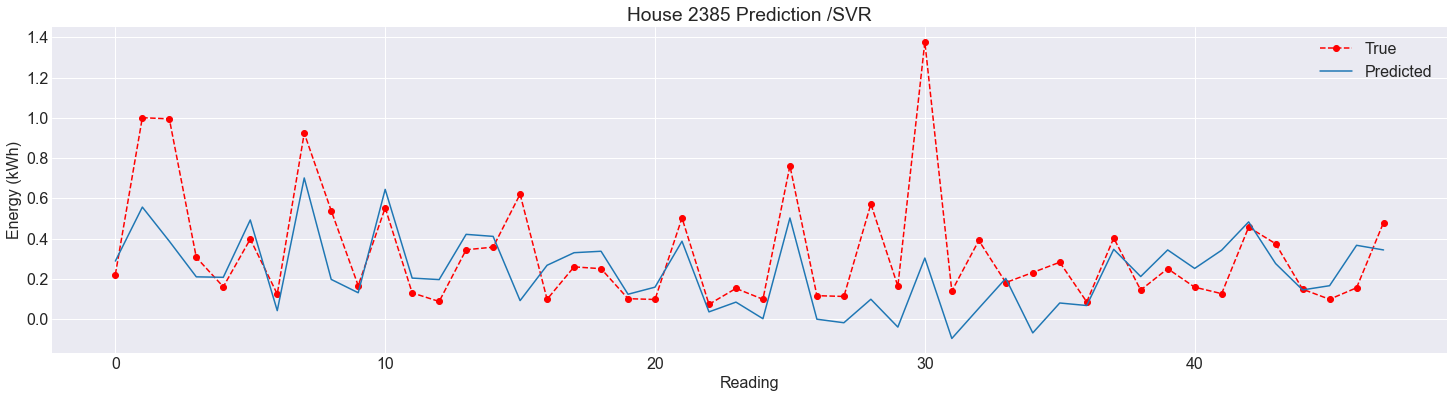

Mse:  0.079006360188434
Rmse: 0.281080700490862
Mae:  0.196816100744304
Mape:  1468.320018614691435


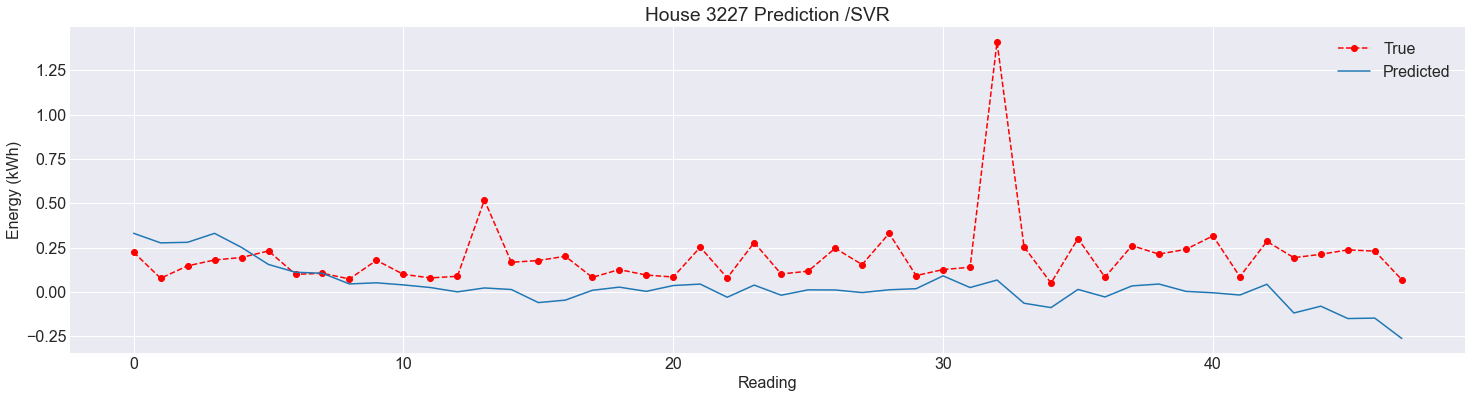

Mse:  0.079231628321874
Rmse: 0.281481133154380
Mae:  0.243457139028420
Mape:  389.356739221955593


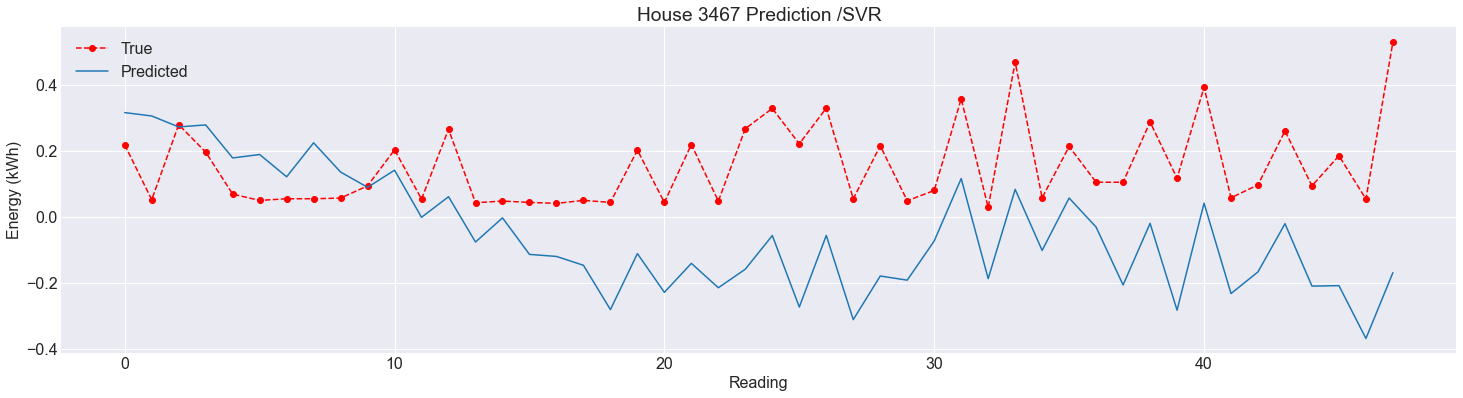

Mse:  0.397259390494564
Rmse: 0.630285166011833
Mae:  0.339447631816791
Mape:  75.803280620475149


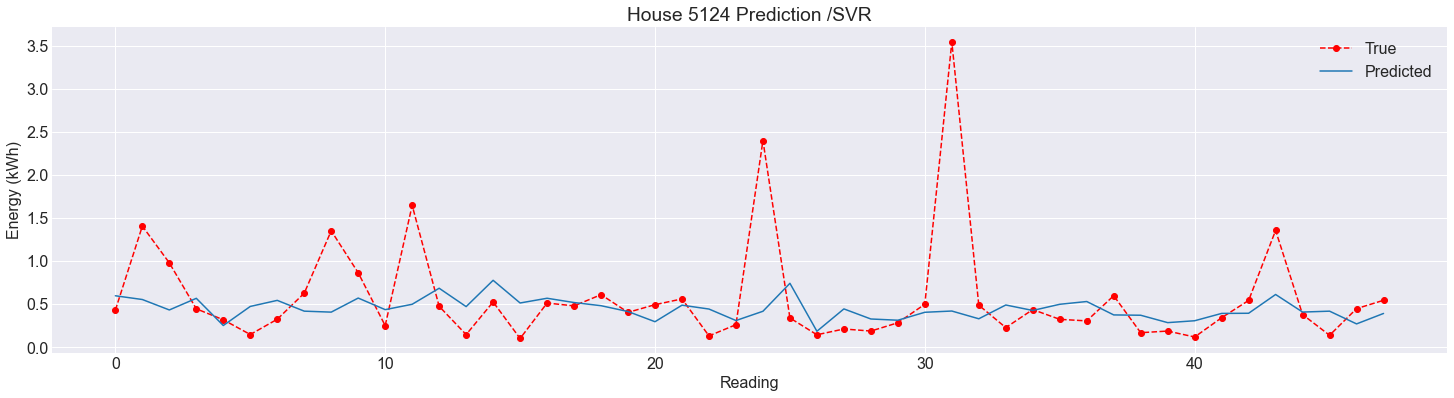

Mse:  0.064652479352662
Rmse: 0.254268518209907
Mae:  0.191582836220341
Mape:  46.162615658256563


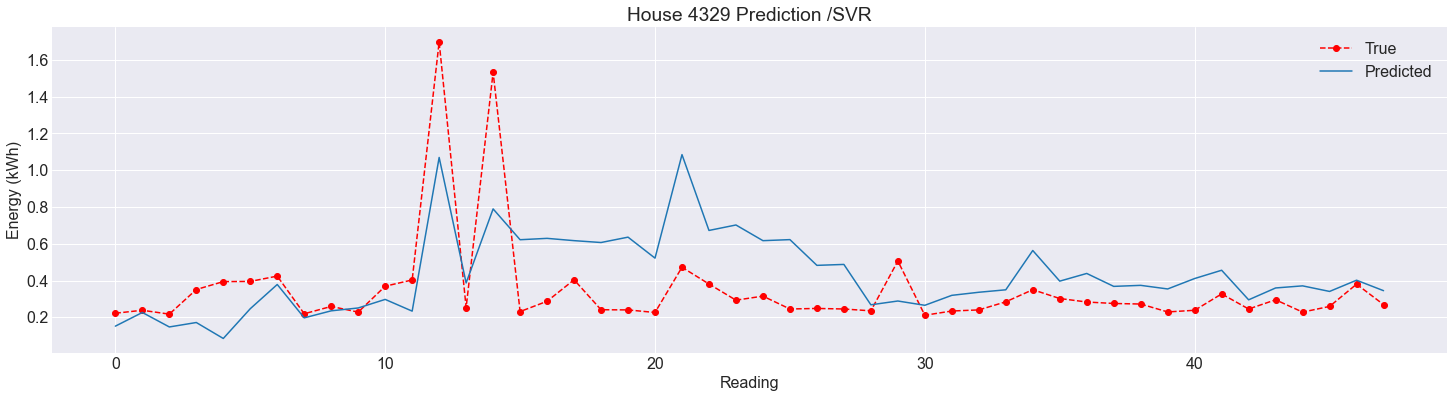

In [137]:
 ##### The households with an error have a '#' 

predict_household_AfterTuning(5492)
predict_household_AfterTuning(2)
predict_household_AfterTuning(3613)
predict_household_AfterTuning(4417)
predict_household_AfterTuning(4957)
predict_household_AfterTuning(3580)
predict_household_AfterTuning(2862)
predict_household_AfterTuning(4539)
predict_household_AfterTuning(336)
predict_household_AfterTuning(3957)
predict_household_AfterTuning(4059)
predict_household_AfterTuning(4151)
predict_household_AfterTuning(754)
predict_household_AfterTuning(1091)
predict_household_AfterTuning(4081)
predict_household_AfterTuning(3430)
predict_household_AfterTuning(3547)
predict_household_AfterTuning(885)
predict_household_AfterTuning(3245)
predict_household_AfterTuning(2883)
predict_household_AfterTuning(2657)
predict_household_AfterTuning(953)
predict_household_AfterTuning(2013)
predict_household_AfterTuning(493)
predict_household_AfterTuning(2385)
predict_household_AfterTuning(3227)
predict_household_AfterTuning(3467)
predict_household_AfterTuning(5124)
predict_household_AfterTuning(4329)


In [ ]:
models_performances_HH_level_Regression = pd.DataFrame([MSE_scores_HH, RMSE_scores_HH, MAE_scores_HH, MAPE_scores_HH],
                                   columns=households_predictions, 
                                   index=['MSE_scores', 'RMSE_scores',
                                          'MAE_scores', 'MAPE_scores'])
models_performances_HH_level_Regression

HH_1        HH_2       HH_3        HH_4       HH_5  \
MSE_scores    0.014725    0.142011   0.201955    0.017413   0.005447   
RMSE_scores   0.121346    0.376843   0.449394    0.131958   0.073804   
MAE_scores    0.074836    0.308814   0.300486    0.087122   0.044320   
MAPE_scores  69.688095  266.572056  92.069269  197.149428  92.626908   

                   HH_6        HH_7       HH_8        HH_9       HH_10  ...  \
MSE_scores     0.092579    0.156427   0.005407    0.231015    0.037792  ...   
RMSE_scores    0.304268    0.395509   0.073533    0.480641    0.194403  ...   
MAE_scores     0.235433    0.321666   0.064300    0.431182    0.152897  ...   
MAPE_scores  273.498587  219.904098  47.904504  134.577396  497.808470  ...   

                  HH_20      HH_21      HH_22       HH_23       HH_24  \
MSE_scores     0.057151   0.085050   0.004409    0.059163    0.050219   
RMSE_scores    0.239063   0.291633   0.066400    0.243234    0.224096   
MAE_scores     0.173946   0.259807   0.055945    0.190042    0.118297   
MAPE_scores  621.158965  70.591502  41.913314  742.493038  712.411148   

                   HH_25        HH_26       HH_27      HH_28      HH_29  
MSE_scores      0.068840     0.071934    0.047444   0.422069   0.047392  
RMSE_scores     0.262374     0.268205    0.217816   0.649669   0.217696  
MAE_scores      0.172339     0.178311    0.187289   0.469459   0.133769  
MAPE_scores  1795.499895  1325.189048  422.491607  81.645271  50.371220  

[4 rows x 29 columns]

In [ ]:
models_performances_HH_level_Regression.to_csv('C:/JET/Masterarbeit/_Masterarbeit/code/CaseStudy1_code/model_performance/models_performances_HH_level_Scenario1_SVR.csv', index=False)